# Figure 5 : Snowline and trend maxima migration
Use the phd_v3 environment (can be replicated from the .yml file in envs/)

In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [65]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


In [3]:
ds_big = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/MARgrid_EUn.nc')[["LON","LAT","SH","FRV","VEG"]]

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False


In [5]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [6]:
def make_ds_seas(path,simcode,vars,first_year,last_year):

    # creating seasonal dataarray with all vars

    ds_yrs = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(first_year)+'.nc')#.resample(time='D').mean()

    for var in vars[1:]:
        ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(first_year)+'.nc')#.resample(time='D').mean()
        ds_yrs[var] = ds_var[var]


    ds_yrs = season_mean(ds_yrs).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

    for year in range(first_year+1,last_year+1):
        print(year,end=' ')
        ds_singleyr = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(year)+'.nc')#.resample(time='D').mean()

        for var in vars[1:]:
            ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(year)+'.nc')#.resample(time='D').mean()
            ds_singleyr[var] = ds_var[var]
    
        print('Computing season mean',end=' ')
        ds_singleyr = season_mean(ds_singleyr).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
        ds_yrs = xr.concat([ds_yrs,ds_singleyr], dim='Year')

    yrs = np.arange(first_year,last_year+1)
    ds_yrs = ds_yrs.assign_coords(Year=("Year", yrs))

    return ds_yrs
    

In [7]:
def altitude_lev_slopes(dataset_slopes,levels):
    ds_slopes_Hlev = dataset_slopes.where(levels[0]).mean(dim=('x','y'))
    ds_slopes_Hlev_std = dataset_slopes.where(levels[0]).std(dim=('x','y'))

    for lev in range(1,len(levels)):
        ds_slopes_Hlev = xr.concat([ds_slopes_Hlev,dataset_slopes.where(levels[lev]).mean(dim=('x','y'))], dim='Hlev')
        ds_slopes_Hlev_std = xr.concat([ds_slopes_Hlev_std,dataset_slopes.where(levels[lev]).std(dim=('x','y'))], dim='Hlev')

    ds_slopes_Hlev = ds_slopes_Hlev.assign_coords(Hlev=("Hlev", H_levels))
    ds_slopes_Hlev_std = ds_slopes_Hlev_std.assign_coords(Hlev=("Hlev", H_levels))

    return ds_slopes_Hlev, ds_slopes_Hlev_std

In [8]:
def spline_fit_4reg(period_slopes,knot_numbers,yfitminpercent=10,yfitmaxpercent=5):

    Nperiods = period_slopes.shape[0]
    
    height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
    height_max = np.full(Nperiods,np.nan) # N periods
    value_max = np.full(Nperiods,np.nan) # N periods
    
    height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps))
    vec_height = height[height.mask == False]
    for i in range(Nperiods):
        slope_seas = 10*np.ma.masked_array(period_slopes[i], mask=np.invert(alps))
        vec_slope_seas = slope_seas[slope_seas.mask == False]
        
        vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_seas), key=lambda pair: pair[0])]
        vec_slope_seas_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_seas), key=lambda pair: pair[0])]
            
        q_knots = np.quantile(vec_height_srt, height_new)
            
        t,c,k = interpolate.splrep(vec_height_srt, vec_slope_seas_srt, t=q_knots, s=1)
        yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
        
        yfitmin = int(yfitminpercent/100*len(yfit))
        yfitmax = int(yfitmaxpercent/100*len(yfit))
        vec_height_srt_redux = vec_height_srt[yfitmin:-yfitmax]
        height_max[i] = vec_height_srt_redux[np.argmax(yfit[yfitmin:-yfitmax])]
        value_max[i] = np.max(yfit[yfitmin:-yfitmax])

    print('k = ',k)
    print(yfitmin, " ",yfitmax,end=" ")
    print(yfit.shape)
    
    return height_max, value_max

In [9]:
def make_ds_snowdays(path,simcode,first_year,last_year,threshold_snow):

    # creating seasonal dataarray with all vars

    var = 'MB'
    
    ds_yrs = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(first_year)+'.nc')#.resample(time='D').mean()

    ds_yrs = ds_yrs.assign_coords(x=ds.x)
    ds_yrs = ds_yrs.assign_coords(y=ds.y)
    ds_yrs_meanMB = ds_yrs.MB.sel(sector=1.0)[:,jmin:jmax,imin:imax]*ds.FRV.sel(sector=1.0)[jmin:jmax,imin:imax]/100 + \
                    ds_yrs.MB.sel(sector=2.0)[:,jmin:jmax,imin:imax]*ds.FRV.sel(sector=2.0)[jmin:jmax,imin:imax]/100 + \
                    ds_yrs.MB.sel(sector=3.0)[:,jmin:jmax,imin:imax]*ds.FRV.sel(sector=3.0)[jmin:jmax,imin:imax]/100
    
    ds_yrs_snowdays = ds_yrs_meanMB >= threshold_snow
    ds_yrs_snowdays_monthly = ds_yrs_snowdays.resample(time='m').sum()

    for year in range(first_year+1,last_year+1):
        print(year,end=' ')
        ds_singleyr = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(year)+'.nc')

        ds_singleyr = ds_singleyr.assign_coords(x=ds.x)
        ds_singleyr = ds_singleyr.assign_coords(y=ds.y)
        ds_singleyr_meanMB = ds_singleyr.MB.sel(sector=1.0)[:,jmin:jmax,imin:imax]*ds.FRV.sel(sector=1.0)[jmin:jmax,imin:imax]/100 + \
                            ds_singleyr.MB.sel(sector=2.0)[:,jmin:jmax,imin:imax]*ds.FRV.sel(sector=2.0)[jmin:jmax,imin:imax]/100 + \
                            ds_singleyr.MB.sel(sector=3.0)[:,jmin:jmax,imin:imax]*ds.FRV.sel(sector=3.0)[jmin:jmax,imin:imax]/100
    
        ds_singleyr_snowdays = ds_singleyr_meanMB >= threshold_snow
        ds_singleyr_snowdays_monthly = ds_singleyr_snowdays.resample(time='m').sum()
        ds_yrs_snowdays_monthly = xr.concat([ds_yrs_snowdays_monthly,ds_singleyr_snowdays_monthly], dim='time')

    #yrs = np.arange(first_year,last_year+1)
    #ds_yrs = ds_yrs.assign_coords(Year=("Year", yrs))

    return ds_yrs_snowdays_monthly
    

In [10]:
# Levels (altitude bands)

levels = [np.logical_and(alps,H<400), np.logical_and(alps,np.logical_and(H>=400,H<600)), np.logical_and(alps,np.logical_and(H>=600,H<800)),
          np.logical_and(alps,np.logical_and(H>=800,H<1000)), np.logical_and(alps,np.logical_and(H>=1000,H<1200)), np.logical_and(alps,np.logical_and(H>=1200,H<1400)),
          np.logical_and(alps,np.logical_and(H>=1400,H<1600)), np.logical_and(alps,np.logical_and(H>=1600,H<1800)), np.logical_and(alps,np.logical_and(H>=1800,H<2000)),
          np.logical_and(alps,np.logical_and(H>=2000,H<2200)), np.logical_and(alps,np.logical_and(H>=2200,H<2400)), np.logical_and(alps,np.logical_and(H>=2400,H<2600)),
          np.logical_and(alps,np.logical_and(H>=2600,H<2800)), np.logical_and(alps,np.logical_and(H>=2800,H<3000)),
          np.logical_and(alps,H>=3000)]#,
          #alps]

H_levels = [300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100]

### Making figure 4 : evolution of maximum warming (and other variables) along rolling 50 year periods

#### Historic variable dataset preparation

In [22]:
ds314_MPI_HIST = make_ds_seas(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/HIST/ICE.MPI-ESM_HIST',simcode='n',
                                vars=['TTz','TTmin','TTmax','ST',
                                      'LWD','LWU','SWD','SWU','SHF','LHF','GF','HAcc','SWt','HA_col','MB','MBm','MBr','MBmTop','MBrTop'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [23]:
# Computing net shortwave and net longwave and saving it
yrs = np.arange(1961,2015)

ds314_MPI_HIST = ds314_MPI_HIST.assign_coords(Year=("Year", yrs))

ds314_MPI_HIST['NSW'] = ds314_MPI_HIST['SWD'] - ds314_MPI_HIST['SWU']
ds314_MPI_HIST['NLW'] = ds314_MPI_HIST['LWD'] - ds314_MPI_HIST['LWU']

ds314_MPI_SSP585['SWt'] = - ds314_MPI_SSP585['SWt'] # - sign for SWt because the energy transmitted to lower layers is LOST by the surface

# Computing energy flux related to melt and refreeze
ds_sect = ds_big
Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
t_timestep = 60*60*24 # 60*60*24 seconds in a day

melt_MBm_top = ds314_MPI_HIST.MBmTop.sel(sector=1.0)*np.array(ds_sect.FRV.sel(sector=1.0))/100 + \
                ds314_MPI_HIST.MBmTop.sel(sector=2.0)*np.array(ds_sect.FRV.sel(sector=2.0))/100 + \
                ds314_MPI_HIST.MBmTop.sel(sector=3.0)*np.array(ds_sect.FRV.sel(sector=3.0))/100
ds_day_melt_top = melt_MBm_top * Lf / t_timestep
ds314_MPI_HIST = ds314_MPI_HIST.assign(melt = -ds_day_melt_top) # minus sign becausemelt energy is lost from surface

freez_MBm_top = ds314_MPI_HIST.MBrTop.sel(sector=1.0)*np.array(ds_sect.FRV.sel(sector=1.0))/100 + \
                ds314_MPI_HIST.MBrTop.sel(sector=2.0)*np.array(ds_sect.FRV.sel(sector=2.0))/100 + \
                ds314_MPI_HIST.MBrTop.sel(sector=3.0)*np.array(ds_sect.FRV.sel(sector=3.0))/100
ds_day_freez_top = freez_MBm_top * Lf / t_timestep
ds314_MPI_HIST = ds314_MPI_HIST.assign(freeze = ds_day_freez_top) 

In [27]:
ds314_MPI_HIST.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds314_Surfbal_vars_1961_2014_seas.npy')

### Loading variables (see Fig4 routine for snowlineand SSP585 dataset)

In [14]:
path = '/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/'
ds314_MPI_HIST = xr.open_dataset(path + 'ds314_Surfbal_vars_1961_2014_seas.npy').isel(atmlay=0,y=slice(jmin,jmax),x=slice(imin,imax)).sel(ztqlev=2.0)

ds314_MPI_HIST

<xarray.Dataset>
Dimensions:     (x: 139, y: 91, sector: 3, Year: 54, season: 4)
Coordinates:
  * x           (x) float32 -259.0 -252.0 -245.0 -238.0 ... 693.0 700.0 707.0
  * y           (y) float32 -168.0 -161.0 -154.0 -147.0 ... 448.0 455.0 462.0
    ztqlev      float32 2.0
    atmlay      float32 0.9997
  * sector      (sector) float32 1.0 2.0 3.0
  * season      (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year        (Year) int64 1961 1962 1963 1964 1965 ... 2011 2012 2013 2014
Data variables: (12/25)
    TTz         (Year, season, y, x) float64 ...
    TTmin       (Year, season, y, x) float64 ...
    TTmax       (Year, season, y, x) float64 ...
    ST          (Year, season, y, x) float64 ...
    LWD         (Year, season, y, x) float64 ...
    LWU         (Year, season, y, x) float64 ...
    ...          ...
    NSW         (Year, season, y, x) float64 ...
    NLW         (Year, season, y, x) float64 ...
    melt        (Year, season, y, x) float64 ...
    freeze      (Year, season, y, x) float64 ...
    melt_top    (Year, season, y, x) float64 ...
    freeze_top  (Year, season, y, x) float64 ...

In [15]:
path = '/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/'
ds314_MPI_SSP585 = xr.open_dataset(path + 'ds314_Surfbal_vars_2015_2100_seas.npy').isel(atmlay=0).sel(ztqlev=2.0)

In [16]:
mean10_snowline = np.load('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/daily_snowline_minmaxaverage_mean10pix_v314.npy')

In [17]:
# Excluding non physical values

ds314_MPI_SSP585 = ds314_MPI_SSP585.where(ds314_MPI_SSP585 != -np.inf)

In [18]:
ds314_MPI_HIST = ds314_MPI_HIST.where(ds314_MPI_HIST != -np.inf)


#### Making spline fits

In [19]:
# Making one dataset for the two periods
ds314_MPI = xr.concat([ds314_MPI_HIST[['TTz','TTmax','ST','melt_top','NSW']],ds314_MPI_SSP585[['TTz','TTmax','ST','melt_top','NSW']]],dim='Year')


<xarray.Dataset>
Dimensions:   (Year: 140, season: 4, y: 91, x: 139)
Coordinates:
  * x         (x) float32 -259.0 -252.0 -245.0 -238.0 ... 693.0 700.0 707.0
  * y         (y) float32 -168.0 -161.0 -154.0 -147.0 ... 448.0 455.0 462.0
    ztqlev    float32 2.0
    atmlay    float32 0.9997
  * season    (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year      (Year) int64 1961 1962 1963 1964 1965 ... 2096 2097 2098 2099 2100
Data variables:
    TTz       (Year, season, y, x) float64 10.45 10.44 10.44 ... 13.49 13.44
    TTmax     (Year, season, y, x) float64 11.4 11.4 11.39 ... 18.23 18.11 18.24
    ST        (Year, season, y, x) float64 12.22 12.21 12.2 ... 14.36 14.32
    melt_top  (Year, season, y, x) float64 -0.0 -0.0 ... -0.02644 -0.0001924
    NSW       (Year, season, y, x) float64 66.88 67.11 67.3 ... 87.53 87.14

In [21]:
ds314_MPI

<xarray.Dataset>
Dimensions:   (Year: 140, season: 4, y: 91, x: 139)
Coordinates:
  * x         (x) float32 -259.0 -252.0 -245.0 -238.0 ... 693.0 700.0 707.0
  * y         (y) float32 -168.0 -161.0 -154.0 -147.0 ... 448.0 455.0 462.0
    ztqlev    float32 2.0
    atmlay    float32 0.9997
  * season    (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year      (Year) int64 1961 1962 1963 1964 1965 ... 2096 2097 2098 2099 2100
Data variables:
    TTz       (Year, season, y, x) float64 10.45 10.44 10.44 ... 13.49 13.44
    TTmax     (Year, season, y, x) float64 11.4 11.4 11.39 ... 18.23 18.11 18.24
    ST        (Year, season, y, x) float64 12.22 12.21 12.2 ... 14.36 14.32
    melt_top  (Year, season, y, x) float64 -0.0 -0.0 ... -0.02644 -0.0001924
    NSW       (Year, season, y, x) float64 66.88 67.11 67.3 ... 87.53 87.14

In [22]:
from scipy.interpolate import UnivariateSpline
from scipy import interpolate

# --- Adaptive spline smoother ---
def spline_smooth_auto(x, y, alpha=1.0, k=3):
    mask = np.isfinite(y)
    if mask.sum() < (k+1):  # not enough points
        return np.full_like(y, np.nan, dtype=float)
    
    n = mask.sum()
    #print('n = ', n)
    var = np.nanvar(y[mask])
    #print('var = ', var)
    s = alpha * var * n   # adaptive smoothing parameter
    #print(s)
    spline = UnivariateSpline(x[mask], y[mask], k=k, s=s)
    return spline(x)  # evaluate back on original x grid

# Convert time -> numeric
yr = ds314_MPI.Year.astype(float).values

# Apply across grid cells
da = ds314_MPI[["TTz","ST","TTmax","NSW","melt_top"]]

# alpha < 1.0 : tighter fit
# alpha > 1.0 : looser fit (more smoothing)
# alpha = 1.0 seems to work best

da_smooth = xr.apply_ufunc(
    spline_smooth_auto,
    yr,
    da,
    kwargs={"alpha": 1.0, "k": 3},   # adjust smoothing strength
    input_core_dims=[["time"], ["Year"]],
    output_core_dims=[["Year"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
)

# Keep original time coords
da_smooth = da_smooth.assign_coords(Year=ds314_MPI.Year)

In [23]:
mean10_minH_snow_seas = np.full((140,4),np.nan)
mean10_maxH_nosnow_seas = np.full((140,4),np.nan)
mean10_average_minmax_snow_seas = np.full((140,4),np.nan)

mean10_snowline_seas = [mean10_minH_snow_seas,mean10_maxH_nosnow_seas,mean10_average_minmax_snow_seas]

for j in range(3):
    mean10_snowline_seas[j][:,0] = np.median(np.concatenate((mean10_snowline[j][:,:59],mean10_snowline[j][:,334:365]),axis=1),axis=1)
    mean10_snowline_seas[j][:,1] = np.median(mean10_snowline[j][:,59:151],axis=1)
    mean10_snowline_seas[j][:,2] = np.median(mean10_snowline[j][:,151:243],axis=1)
    mean10_snowline_seas[j][:,3] = np.median(mean10_snowline[j][:,243:334],axis=1)

In [24]:
Nperiods = 91

rollmean_50yrs_mean10_minH_snow_MAM = np.full(Nperiods,np.nan)
rollmean_50yrs_mean10_maxH_nosnow_MAM = np.full(Nperiods,np.nan)
rollmean_50yrs_mean10_average_minmax_snow_MAM = np.full(Nperiods,np.nan)

rollmean_50yrs_mean10_minH_snow_JJA = np.full(Nperiods,np.nan)
rollmean_50yrs_mean10_maxH_nosnow_JJA = np.full(Nperiods,np.nan)
rollmean_50yrs_mean10_average_minmax_snow_JJA = np.full(Nperiods,np.nan)

rollmean_50yrs_mean10_minH_snow_SON = np.full(Nperiods,np.nan)
rollmean_50yrs_mean10_maxH_nosnow_SON = np.full(Nperiods,np.nan)
rollmean_50yrs_mean10_average_minmax_snow_SON = np.full(Nperiods,np.nan)

rollmean_50yrs_mean10_minH_snow_DJF = np.full(Nperiods,np.nan)
rollmean_50yrs_mean10_maxH_nosnow_DJF = np.full(Nperiods,np.nan)
rollmean_50yrs_mean10_average_minmax_snow_DJF = np.full(Nperiods,np.nan)

for i in range(Nperiods):
    end = i+50
    seas = 1
    rollmean_50yrs_mean10_minH_snow_MAM[i] = mean10_snowline_seas[0][i:end,seas].mean()
    rollmean_50yrs_mean10_maxH_nosnow_MAM[i] = mean10_snowline_seas[1][i:end,seas].mean()
    rollmean_50yrs_mean10_average_minmax_snow_MAM[i] = mean10_snowline_seas[2][i:end,seas].mean()

    seas = 2
    rollmean_50yrs_mean10_minH_snow_JJA[i] = mean10_snowline_seas[0][i:end,seas].mean()
    rollmean_50yrs_mean10_maxH_nosnow_JJA[i] = mean10_snowline_seas[1][i:end,seas].mean()
    rollmean_50yrs_mean10_average_minmax_snow_JJA[i] = mean10_snowline_seas[2][i:end,seas].mean()

    seas = 3
    rollmean_50yrs_mean10_minH_snow_SON[i] = mean10_snowline_seas[0][i:end,seas].mean()
    rollmean_50yrs_mean10_maxH_nosnow_SON[i] = mean10_snowline_seas[1][i:end,seas].mean()
    rollmean_50yrs_mean10_average_minmax_snow_SON[i] = mean10_snowline_seas[2][i:end,seas].mean()

    seas = 0
    rollmean_50yrs_mean10_minH_snow_DJF[i] = mean10_snowline_seas[0][i:end,seas].mean()
    rollmean_50yrs_mean10_maxH_nosnow_DJF[i] = mean10_snowline_seas[1][i:end,seas].mean()
    rollmean_50yrs_mean10_average_minmax_snow_DJF[i] = mean10_snowline_seas[2][i:end,seas].mean()

#### Take difference between last and first value of each window/period

In [25]:
l = 50 # length of periods

n = 140-l+1 # number of periods

slopes_periods = (da_smooth.isel(Year=49) - da_smooth.isel(Year=0)) / l

for year in np.arange(1,n):
    print(year,end=' ')
    endyear = year+l-1
    period_slope = (da_smooth.isel(Year=endyear) - da_smooth.isel(Year=year)) / l
    slopes_periods = xr.concat([slopes_periods,period_slope], dim='period')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 

In [26]:
periods = np.arange(0,91)

slopes_periods = slopes_periods.assign_coords(period=("period", periods))

slopes_periods

<xarray.Dataset>
Dimensions:   (x: 139, y: 91, season: 4, period: 91)
Coordinates:
  * x         (x) float32 -259.0 -252.0 -245.0 -238.0 ... 693.0 700.0 707.0
  * y         (y) float32 -168.0 -161.0 -154.0 -147.0 ... 448.0 455.0 462.0
    ztqlev    float32 2.0
    atmlay    float32 0.9997
  * season    (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * period    (period) int64 0 1 2 3 4 5 6 7 8 9 ... 82 83 84 85 86 87 88 89 90
Data variables:
    TTz       (period, season, y, x) float64 0.00196 0.002083 ... 0.06304
    ST        (period, season, y, x) float64 0.009815 0.01019 ... 0.0631 0.06275
    TTmax     (period, season, y, x) float64 0.002465 0.002546 ... 0.0752
    NSW       (period, season, y, x) float64 -0.03654 -0.03418 ... 0.1136 0.1107
    melt_top  (period, season, y, x) float64 0.0 0.0 0.0 ... 0.002048 0.002009

### Appendix C figure

355 10


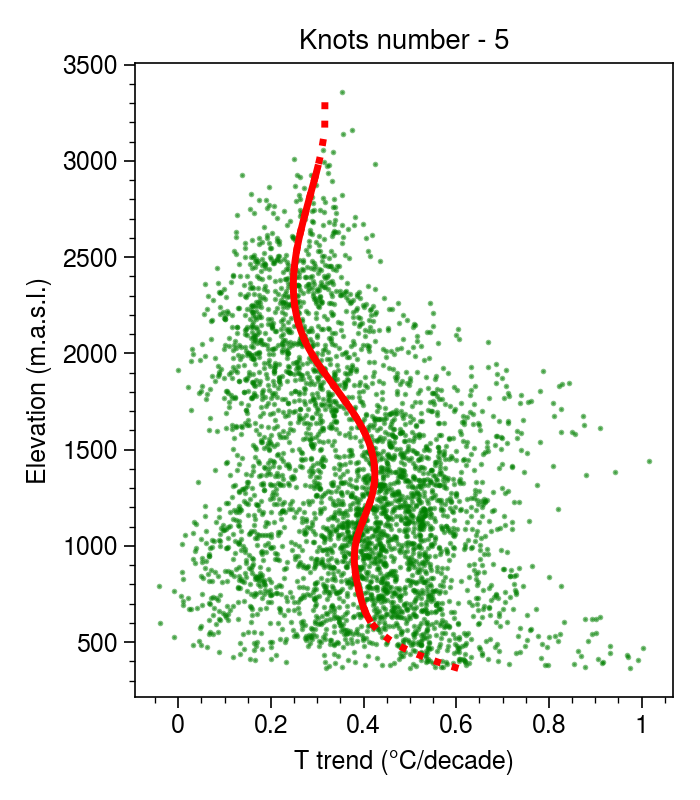

In [27]:
pplt.rc['figure.facecolor'] = 'white'

period=10

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps))
vec_height = height[height.mask == False]

slope_NSW_MAM = 10*np.ma.masked_array(slopes_periods['TTz'].sel(season='MAM')[period], mask=np.invert(alps))
vec_slope_NSW_MAM = slope_NSW_MAM[slope_NSW_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_NSW_MAM), key=lambda pair: pair[0])]
vec_slope_NSW_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_NSW_MAM), key=lambda pair: pair[0])]


knots = [5]
j=0

ig, ax = plt.subplots(figsize=(3.5, 4))

vec_slope_seas_srt = vec_slope_NSW_MAM_srt
yfitminpercent=10
yfitmaxpercent=0.3
# yfitminpercent=0.1
# yfitmaxpercent=0.1
multiplier = 10

ax.plot(multiplier*np.array(vec_slope_NSW_MAM_srt),vec_height_srt, '.',c="g", markersize=2,alpha=0.5)

height_new = np.linspace(0, 1, knots[j]+2)[1:-1]
q_knots = np.quantile(vec_height_srt, height_new)

t,c,k = interpolate.splrep(vec_height_srt, vec_slope_seas_srt, t=q_knots, s=1)
yfit = interpolate.BSpline(t,c,k)(vec_height_srt)

yfitmin = int(yfitminpercent/100*len(yfit))
yfitmax = int(yfitmaxpercent/100*len(yfit))
vec_height_srt_redux = vec_height_srt[yfitmin:-yfitmax]
print(yfitmin,yfitmax)
ax.plot(multiplier*np.array(yfit[yfitmin:-yfitmax]),vec_height_srt[yfitmin:-yfitmax], 'r',linewidth=2.5)
ax.plot(multiplier*np.array(yfit),vec_height_srt, 'r:',linewidth=2.5)
ax.set_title("Knots number - "+str(knots[j]))
ax.set_xlabel('T trend (°C/decade)')
ax.set_ylabel('Elevation (m.a.s.l.)')
ax.grid()
        
plt.tight_layout()        
plt.show()

In [28]:
maxpercent = 0.3
minpercent = 10

height_max_T_k5_MAM, value_max_T_k5_MAM = spline_fit_4reg(slopes_periods['TTz'].sel(season='MAM'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

height_max_Tmax_k5_MAM, value_max_Tmax_k5_MAM = spline_fit_4reg(slopes_periods['TTmax'].sel(season='MAM'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

height_max_ST_k5_MAM, value_max_ST_k5_MAM = spline_fit_4reg(slopes_periods['ST'].sel(season='MAM'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

height_max_NSW_k5_MAM, value_max_NSW_k5_MAM = spline_fit_4reg(slopes_periods['NSW'].sel(season='MAM'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

height_max_melt_top_k5_MAM, value_max_melt_top_k5_MAM = spline_fit_4reg(slopes_periods['melt_top'].sel(season='MAM'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

k =  3
355   10 (3551,)
k =  3
355   10 (3551,)
k =  3
355   10 (3551,)
k =  3
355   10 (3551,)
k =  3
355   10 (3551,)


In [29]:
maxpercent = 0.3
minpercent = 10

height_max_T_k5_JJA, value_max_T_k5_JJA = spline_fit_4reg(slopes_periods['TTz'].sel(season='JJA'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

height_max_Tmax_k5_JJA, value_max_Tmax_k5_JJA = spline_fit_4reg(slopes_periods['TTmax'].sel(season='JJA'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

height_max_ST_k5_JJA, value_max_ST_k5_JJA = spline_fit_4reg(slopes_periods['ST'].sel(season='JJA'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

height_max_NSW_k5_JJA, value_max_NSW_k5_JJA = spline_fit_4reg(slopes_periods['NSW'].sel(season='JJA'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

height_max_melt_top_k5_JJA, value_max_melt_top_k5_JJA = spline_fit_4reg(slopes_periods['melt_top'].sel(season='JJA'),
                                                          knot_numbers=5,yfitminpercent=minpercent,yfitmaxpercent=maxpercent)

k =  3
355   10 (3551,)
k =  3
355   10 (3551,)
k =  3
355   10 (3551,)
k =  3
355   10 (3551,)
k =  3
355   10 (3551,)


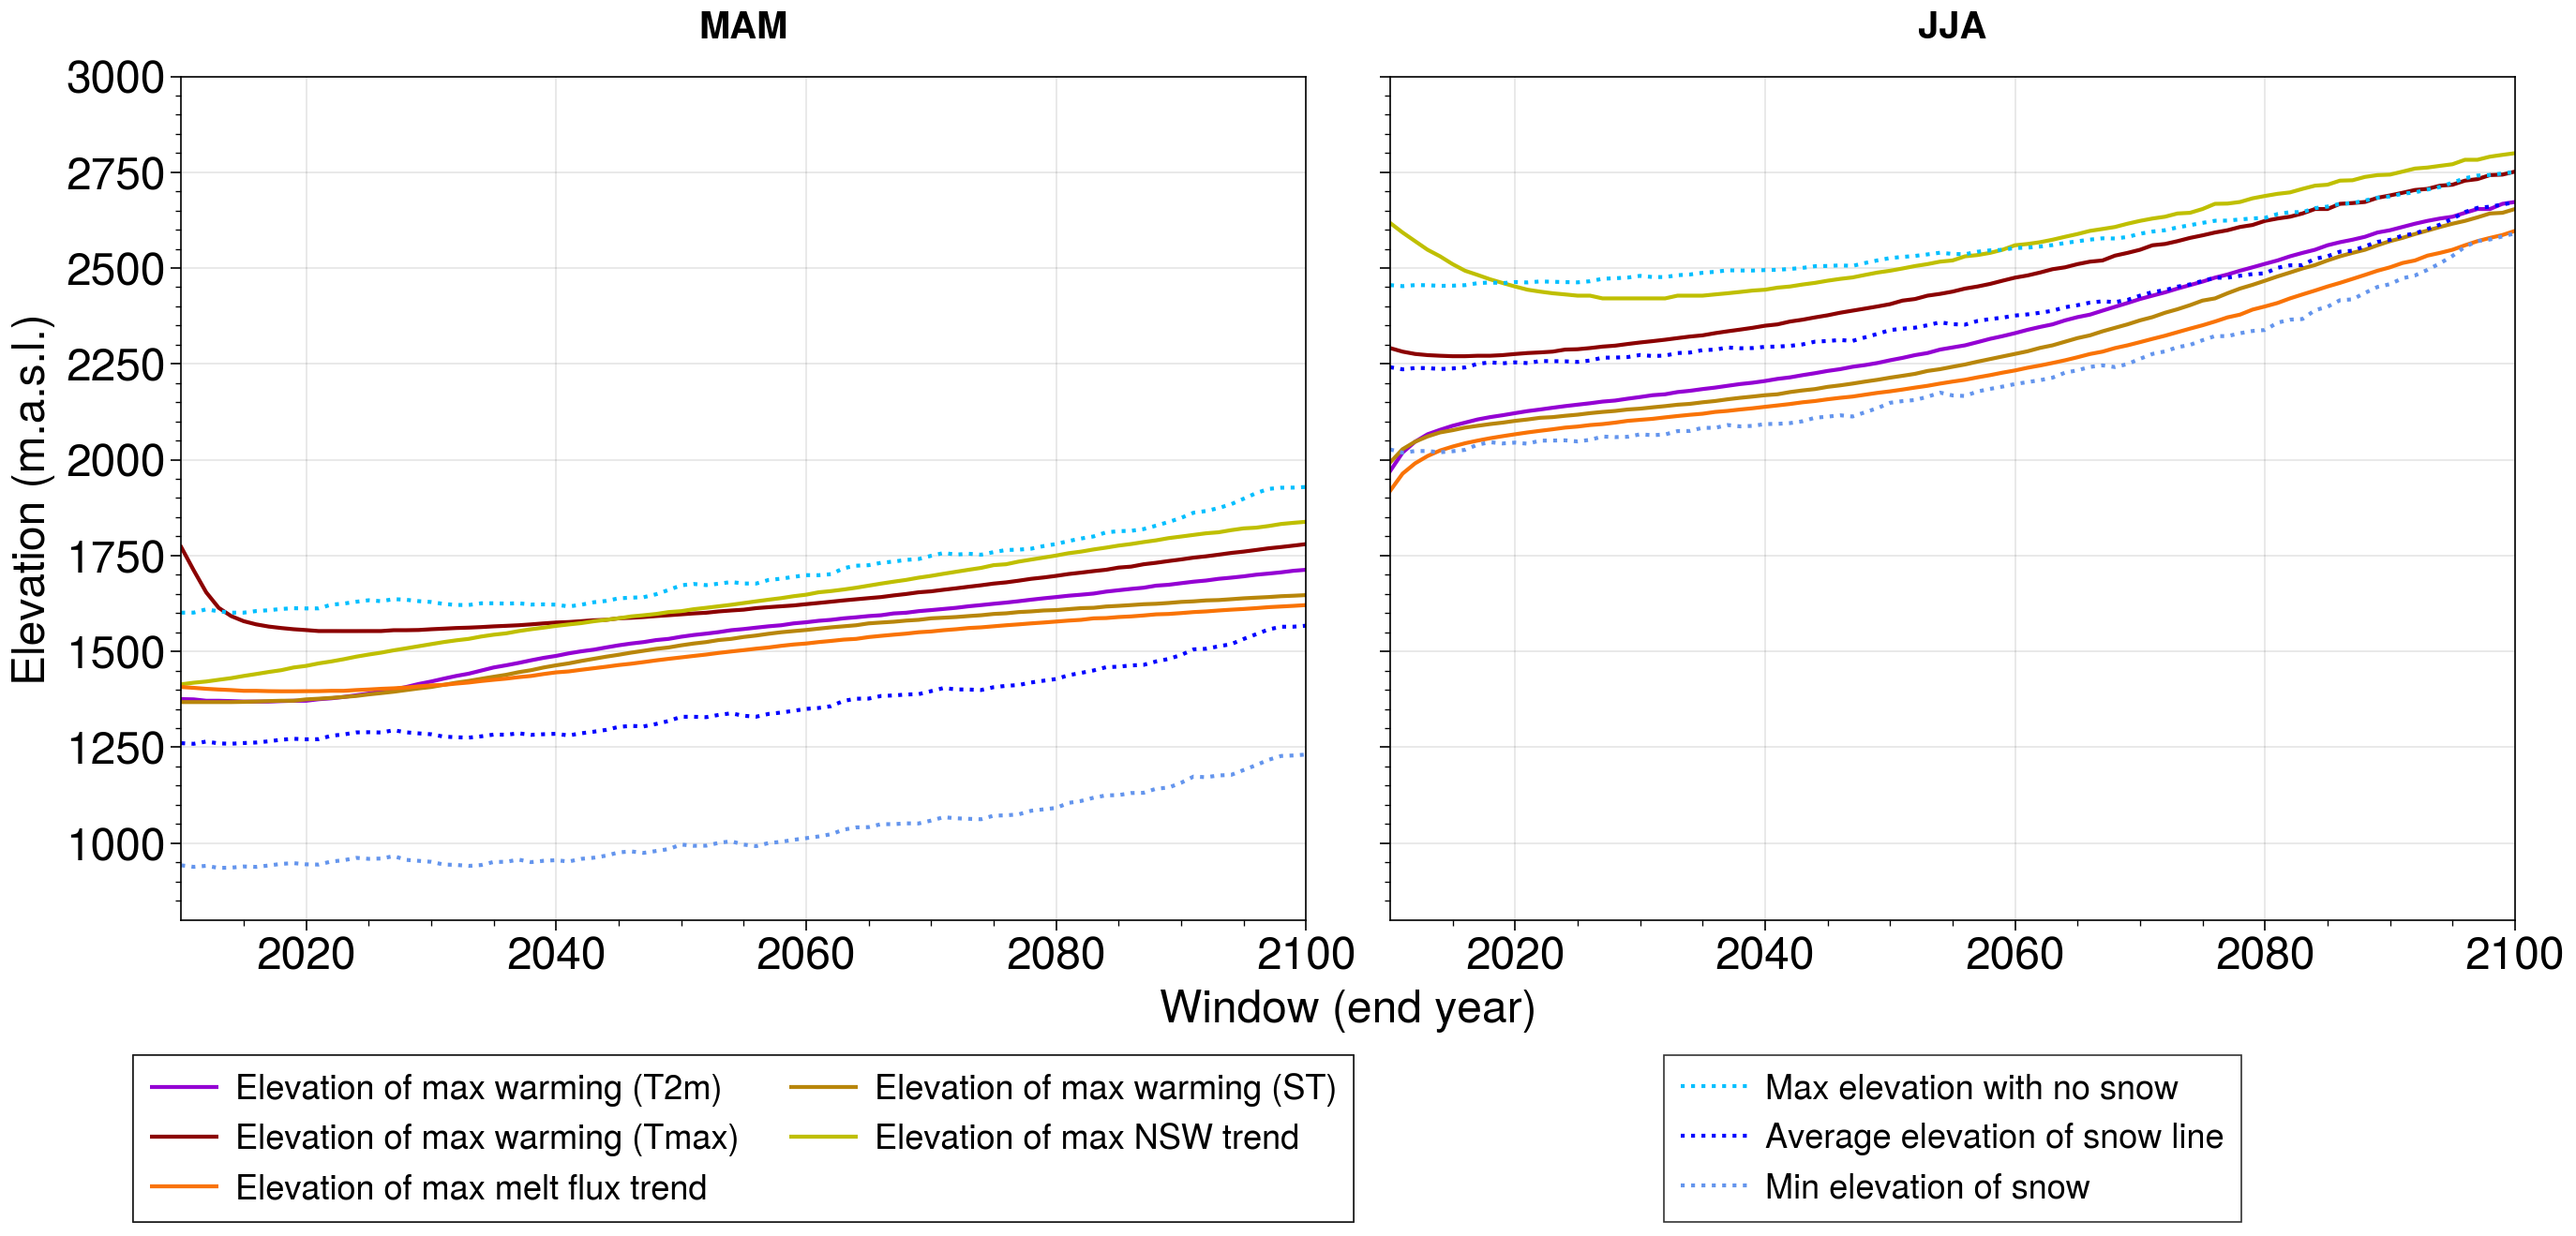

In [30]:
pplt.rc['figure.facecolor'] = 'white'


f,axs = pplt.subplots(axwidth=6,axheight=4.5,ncols=2)

periods = range(1,91)
periods = range(2010,2101)

# Spring - MAM
line1, = axs[0].plot(periods,height_max_T_k5_MAM,label='Elevation of max warming (T2m)',c='darkviolet')#,legend_kw={'fontsize':'30px'})
line2, = axs[0].plot(periods,height_max_ST_k5_MAM,label='Elevation of max warming (ST)',c='darkgoldenrod')

line3, = axs[0].plot(periods,height_max_Tmax_k5_MAM,c='darkred',label='Elevation of max warming (Tmax)')
line4, = axs[0].plot(periods,height_max_NSW_k5_MAM,c='y',label='Elevation of max NSW trend')
line5, = axs[0].plot(periods,height_max_melt_top_k5_MAM,c='orange',label='Elevation of max melt flux trend')
lines_solid = [line1, line2, line3, line4, line5]

line6, = axs[0].plot(periods,rollmean_50yrs_mean10_minH_snow_MAM,c='cornflowerblue',linestyle=':',label='Min elevation of snow')
line7, = axs[0].plot(periods,rollmean_50yrs_mean10_maxH_nosnow_MAM,c='deepskyblue',linestyle=':',label='Max elevation with no snow')
line8, = axs[0].plot(periods,rollmean_50yrs_mean10_average_minmax_snow_MAM,c='b',linestyle=':',label='Average elevation of snow line')
#axs[0].plot(rollmean_50yrs_mean1_minH_snow_MAM[0],c='lightskyblue',linestyle='--')
#axs[0].plot(rollmean_50yrs_mean1_maxH_nosnow_MAM[0],c='deepskyblue',linestyle='--')
#axs[0].plot(rollmean_50yrs_mean1_average_minmax_snow_MAM[0],c='skyblue',linestyle='--')
lines_dashed = [line7, line8, line6]

# Summer - JJA
axs[1].plot(periods,height_max_T_k5_JJA,c='darkviolet')#,legend_kw={'fontsize':'30px'})
axs[1].plot(periods,height_max_ST_k5_JJA,c='darkgoldenrod')

axs[1].plot(periods,height_max_Tmax_k5_JJA,c='darkred')
axs[1].plot(periods,height_max_NSW_k5_JJA,c='y')
axs[1].plot(periods,height_max_melt_top_k5_JJA,c='orange')


axs[1].plot(periods,rollmean_50yrs_mean10_minH_snow_JJA,c='cornflowerblue',linestyle=':')
axs[1].plot(periods,rollmean_50yrs_mean10_maxH_nosnow_JJA,c='deepskyblue',linestyle=':')
axs[1].plot(periods,rollmean_50yrs_mean10_average_minmax_snow_JJA,c='b',linestyle=':')

#f.legend(loc='b',prop = { "size": 16 })
# Create two separate legend boxes
leg1 = f.legend(handles=lines_solid, loc="b",prop = { "size": 13 },col=1,ncols=2)#title="Fluxes",
leg2 = f.legend(handles=lines_dashed, loc="b",prop = { "size": 13 },col=2,ncols=1)#title="Temperatures",

# Ensure both are displayed
f.add_artist(leg1)

axs.format(ylim=[800,3000],ylabel='Elevation (m.a.s.l.)',xlabel='Window (end year)',fontsmallsize='24px',collabels=['MAM','JJA'],fontlargesize='20px')

### Appendix A: comparing MAR simulations to gridded observational datasets and satellite observations for snow

#### Making datasets

In [21]:
ds_v310_EC = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST',simcode='e',vars=['TTz','MB','MBrr','MBsf'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [22]:
ds_v310_EC["precip"] = ds_v310_EC["MBrr"] + ds_v310_EC["MBsf"]

In [23]:
ds_v310_EC.to_netcdf('/bettik/castelli/data/saved_data_MAR_ECEarth3/HIST/ds_TTz_MB_precip_1961_2014_seas.npy')

In [21]:
ds_v310_ = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST',simcode='y',vars=['TTz','MB','MBrr','MBsf'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [22]:
ds_v310_["precip"] = ds_v310_["MBrr"] + ds_v310_["MBsf"]

In [24]:
ds_v310_.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds_TTz_MB_precip_1961_2015_seas.npy')

In [26]:
ds_v314_ = make_ds_seas(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/HIST/ICE.MPI-ESM_HIST',simcode='n',vars=['TTz','MB','MBrr','MBsf'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [27]:
ds_v314_["precip"] = ds_v314_["MBrr"] + ds_v314_["MBsf"]

In [28]:
ds_v314_.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds314_TTz_MB_precip_1961_2015_seas.npy')

In [49]:
ds_v310_fut = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585',simcode='y',vars=['TTz','MB','MBrr','MBsf'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [50]:
ds_v310_fut["precip"] = ds_v310_fut["MBrr"] + ds_v310_fut["MBsf"]

In [51]:
ds_v310_fut.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/ds_TTz_MB_precip_2015_2100_seas.npy')

In [52]:
ds_v314_fut = make_ds_seas(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/SSP585/ICE.MPI-ESM_SSP585',simcode='n',vars=['TTz','MB','MBrr','MBsf'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [53]:
ds_v314_fut["precip"] = ds_v314_fut["MBrr"] + ds_v314_fut["MBsf"]

In [54]:
ds_v314_fut.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/ds314_TTz_MB_precip_2015_2100_seas.npy')

### Loading data
For EOBS and APGD data,can be procured through the following link : https://surfobs.climate.copernicus.eu/surfobs.php

In [11]:
ds_APGD = xr.open_dataset('/bettik/menegozm/EURO4M_APGD/06-coord_lonlat.nc')
ds_APGD = ds_APGD.rename_vars({'Longitude':'LON','Latitude':'LAT'})

In [12]:
ds_APGD_seas = season_mean(xr.open_dataset('/bettik/castelli/data/EURO4M_APGD/APGD_1971.nc').PRECIPITATION).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],
                                                                                                                                dims=['season']))

for year in range(1972,2009):
    print(year,end = ' ')
    ds_yr = season_mean(xr.open_dataset('/bettik/castelli/data/EURO4M_APGD/APGD_'+str(year)+'.nc').PRECIPITATION).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],
                                                                                                                                dims=['season']))
    ds_APGD_seas = xr.concat([ds_APGD_seas,ds_yr], dim='Year')

1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 

In [13]:
yrs = np.arange(1971,2009)
ds_APGD_seas = ds_APGD_seas.assign_coords(Year=("Year", yrs))

In [14]:
ds_TG_EOBS = xr.open_dataset('/bettik/castelli/data/E-OBS/tg_ens_mean_0.1deg_reg_v29.0e.nc').tg.isel(latitude=np.arange(170,250,1),longitude=np.arange(280,430,1))
ds_TG_EOBS

<xarray.DataArray 'tg' (time: 27028, latitude: 80, longitude: 150)>
[324336000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 42.05 42.15 42.25 42.35 ... 49.75 49.85 49.95
  * longitude  (longitude) float64 3.05 3.15 3.25 3.35 ... 17.75 17.85 17.95
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2023-12-31
Attributes:
    units:          Celsius
    long_name:      mean temperature
    standard_name:  air_temperature
    cell_methods:   time: mean

In [30]:
ds_elev_EOBS = xr.open_dataset('/bettik/castelli/data/E-OBS/elev_ens_0.1deg_reg_v29.0e.nc').isel(latitude=np.arange(170,250,1),longitude=np.arange(280,430,1))
ds_elev_EOBS.elevation

<xarray.DataArray 'elevation' (latitude: 80, longitude: 150)>
[12000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 3.05 3.15 3.25 3.35 ... 17.75 17.85 17.95
  * latitude   (latitude) float64 42.05 42.15 42.25 42.35 ... 49.75 49.85 49.95
Attributes:
    units:      metres
    long_name:  Elevation

In [15]:
ds_TG_EOBS_seas = season_mean(ds_TG_EOBS.sel(time='1950')).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))


for year in range(1951,2024):
    print(year,end = ' ')
    ds_seas = season_mean(ds_TG_EOBS.sel(time=str(year))).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

    ds_TG_EOBS_seas = xr.concat([ds_TG_EOBS_seas,ds_seas], dim='Year')

yrs = np.arange(1950,2024)
ds_TG_EOBS_seas = ds_TG_EOBS_seas.assign_coords(Year=("Year", yrs))

1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 

In [26]:
ds_TG_EOBS

<xarray.DataArray 'tg' (time: 27028, latitude: 80, longitude: 150)>
[324336000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 42.05 42.15 42.25 42.35 ... 49.75 49.85 49.95
  * longitude  (longitude) float64 3.05 3.15 3.25 3.35 ... 17.75 17.85 17.95
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2023-12-31
Attributes:
    units:          Celsius
    long_name:      mean temperature
    standard_name:  air_temperature
    cell_methods:   time: mean

In [16]:
ds_v310_EC = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_ECEarth3/HIST/ds_TTz_MB_precip_1961_2014_seas.npy')

In [70]:
ds_v310_ = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds_TTz_MB_precip_1961_2015_seas.npy')

In [18]:
ds_v314_ = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds314_TTz_MB_precip_1961_2015_seas.npy')

In [19]:
# Slight differences in coordinates between MAR versions give problems further on

ds_v310_ = ds_v310_.assign_coords(x=ds_v314_.x)
ds_v310_ = ds_v310_.assign_coords(y=ds_v314_.y)


### Regridding

In [20]:
def regridding_MAR(ds_MAR, ds_target_regrid):
    # Using Mickael Lalande's function in utils, otherwise just use regridder from xesmf

    # MAR has a very slight difference in x and y positions of grid cells between MARgrid and the simulations, which will prevent the regridding. So have to do this :
    lon_correct_xy = ds.LON[jmin:jmax,imin:imax] # copy the incorrect lon/lat
    lat_correct_xy = ds.LAT[jmin:jmax,imin:imax]

    lon_correct_xy["x"] = ("x", ds_MAR.x.values) # correct lon
    lon_correct_xy["y"] = ("y", ds_MAR.y.values)

    lat_correct_xy["x"] = ("x", ds_MAR.x.values) # correct lat
    lat_correct_xy["y"] = ("y", ds_MAR.y.values)

    ds_MAR.coords['lon'] = lon_correct_xy
    ds_MAR.coords['lat'] = lat_correct_xy

    ds_MAR_regrid = u.regrid(ds_MAR,ds_target_regrid,'bilinear',globe=True,periodic=False,
                                   reuse_weights=False) # globe=False gives an error, because of scipy.sparse.csr_matrix(X) in add_matrix_NaNs
    return ds_MAR_regrid

In [21]:
def regridding_onto_MAR(ds_in, ds_MAR_target_regrid):
    # Using Mickael Lalande's function in utils, otherwise just use regridder from xesmf

    # MAR has a very slight difference in x and y positions of grid cells between MARgrid and the simulations, which will prevent the regridding. So have to do this :
    lon_correct_xy = ds.LON[jmin:jmax,imin:imax] # copy the incorrect lon/lat
    lat_correct_xy = ds.LAT[jmin:jmax,imin:imax]

    lon_correct_xy["x"] = ("x", ds_MAR_target_regrid.x.values) # correct lon
    lon_correct_xy["y"] = ("y", ds_MAR_target_regrid.y.values)

    lat_correct_xy["x"] = ("x", ds_MAR_target_regrid.x.values) # correct lat
    lat_correct_xy["y"] = ("y", ds_MAR_target_regrid.y.values)

    ds_MAR_target_regrid.coords['lon'] = lon_correct_xy
    ds_MAR_target_regrid.coords['lat'] = lat_correct_xy

    ds_in_regrid = u.regrid(ds_in,ds_MAR_target_regrid,'bilinear',globe=True,periodic=False,
                                   reuse_weights=False) # globe=False gives an error, because of scipy.sparse.csr_matrix(X) in add_matrix_NaNs
    return ds_in_regrid

In [22]:
ds_v310_EC_T_regrid = regridding_MAR(ds_v310_EC.TTz.isel(ztqlev=0)[:,:,jmin:jmax,imin:imax], ds_TG_EOBS_seas)

In [23]:
ds_v310_T_regrid = regridding_MAR(ds_v310_.TTz.isel(ztqlev=0)[:,:,jmin:jmax,imin:imax], ds_TG_EOBS_seas)

In [24]:
ds_v314_T_regrid = regridding_MAR(ds_v314_.TTz.isel(ztqlev=0)[:,:,jmin:jmax,imin:imax], ds_TG_EOBS_seas)

In [38]:
ds_TG_EOBS_seas

<xarray.DataArray (Year: 74, season: 4, latitude: 80, longitude: 150)>
array([[[[ 8.48022202,  8.56311092,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 8.53588871,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 8.70055533,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 2.5115555 ,  2.42666662,  2.32533327, ...,  0.51199999,
           0.17755556, -0.47899999],
         [ 2.39266661,  2.28155548,  2.23622218, ...,  1.32455551,
           0.15488889, -0.5501111 ],
         [ 2.25888886,  2.18499994,  2.11922214, ..., -0.06944444,
          -0.98166663, -1.20255555]],

        [[13.76934747, 13.68619537,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [13.8203258 ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [13.97315185,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
...
         [19.31391276, 19.202717  , 19.14543444, ..., 18.17662998,
          18.3555431 , 18.77967352],
         [19.1642387 , 19.04739096, 19.01510824, ..., 18.37195609,
          18.49749961, 18.31739093],
         [19.0717387 , 19.01108662, 18.96293431, ..., 18.84728216,
          19.03467343, 19.02858649]],

        [[17.68065894, 17.63351606,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [17.55230719,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [18.16417542,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [13.96417546, 13.85296669, 13.72109864, ..., 10.5769228 ,
          10.79329645, 11.24593387],
         [13.85439535, 13.7059337 , 13.61076896, ..., 10.77307664,
          10.96945031, 10.87428546],
         [13.76692277, 13.63593381, 13.55582389, ..., 11.17890083,
          11.46714261, 11.55384591]]]])
Coordinates:
  * latitude   (latitude) float64 42.05 42.15 42.25 42.35 ... 49.75 49.85 49.95
  * longitude  (longitude) float64 3.05 3.15 3.25 3.35 ... 17.75 17.85 17.95
  * season     (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year       (Year) int64 1950 1951 1952 1953 1954 ... 2020 2021 2022 2023

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

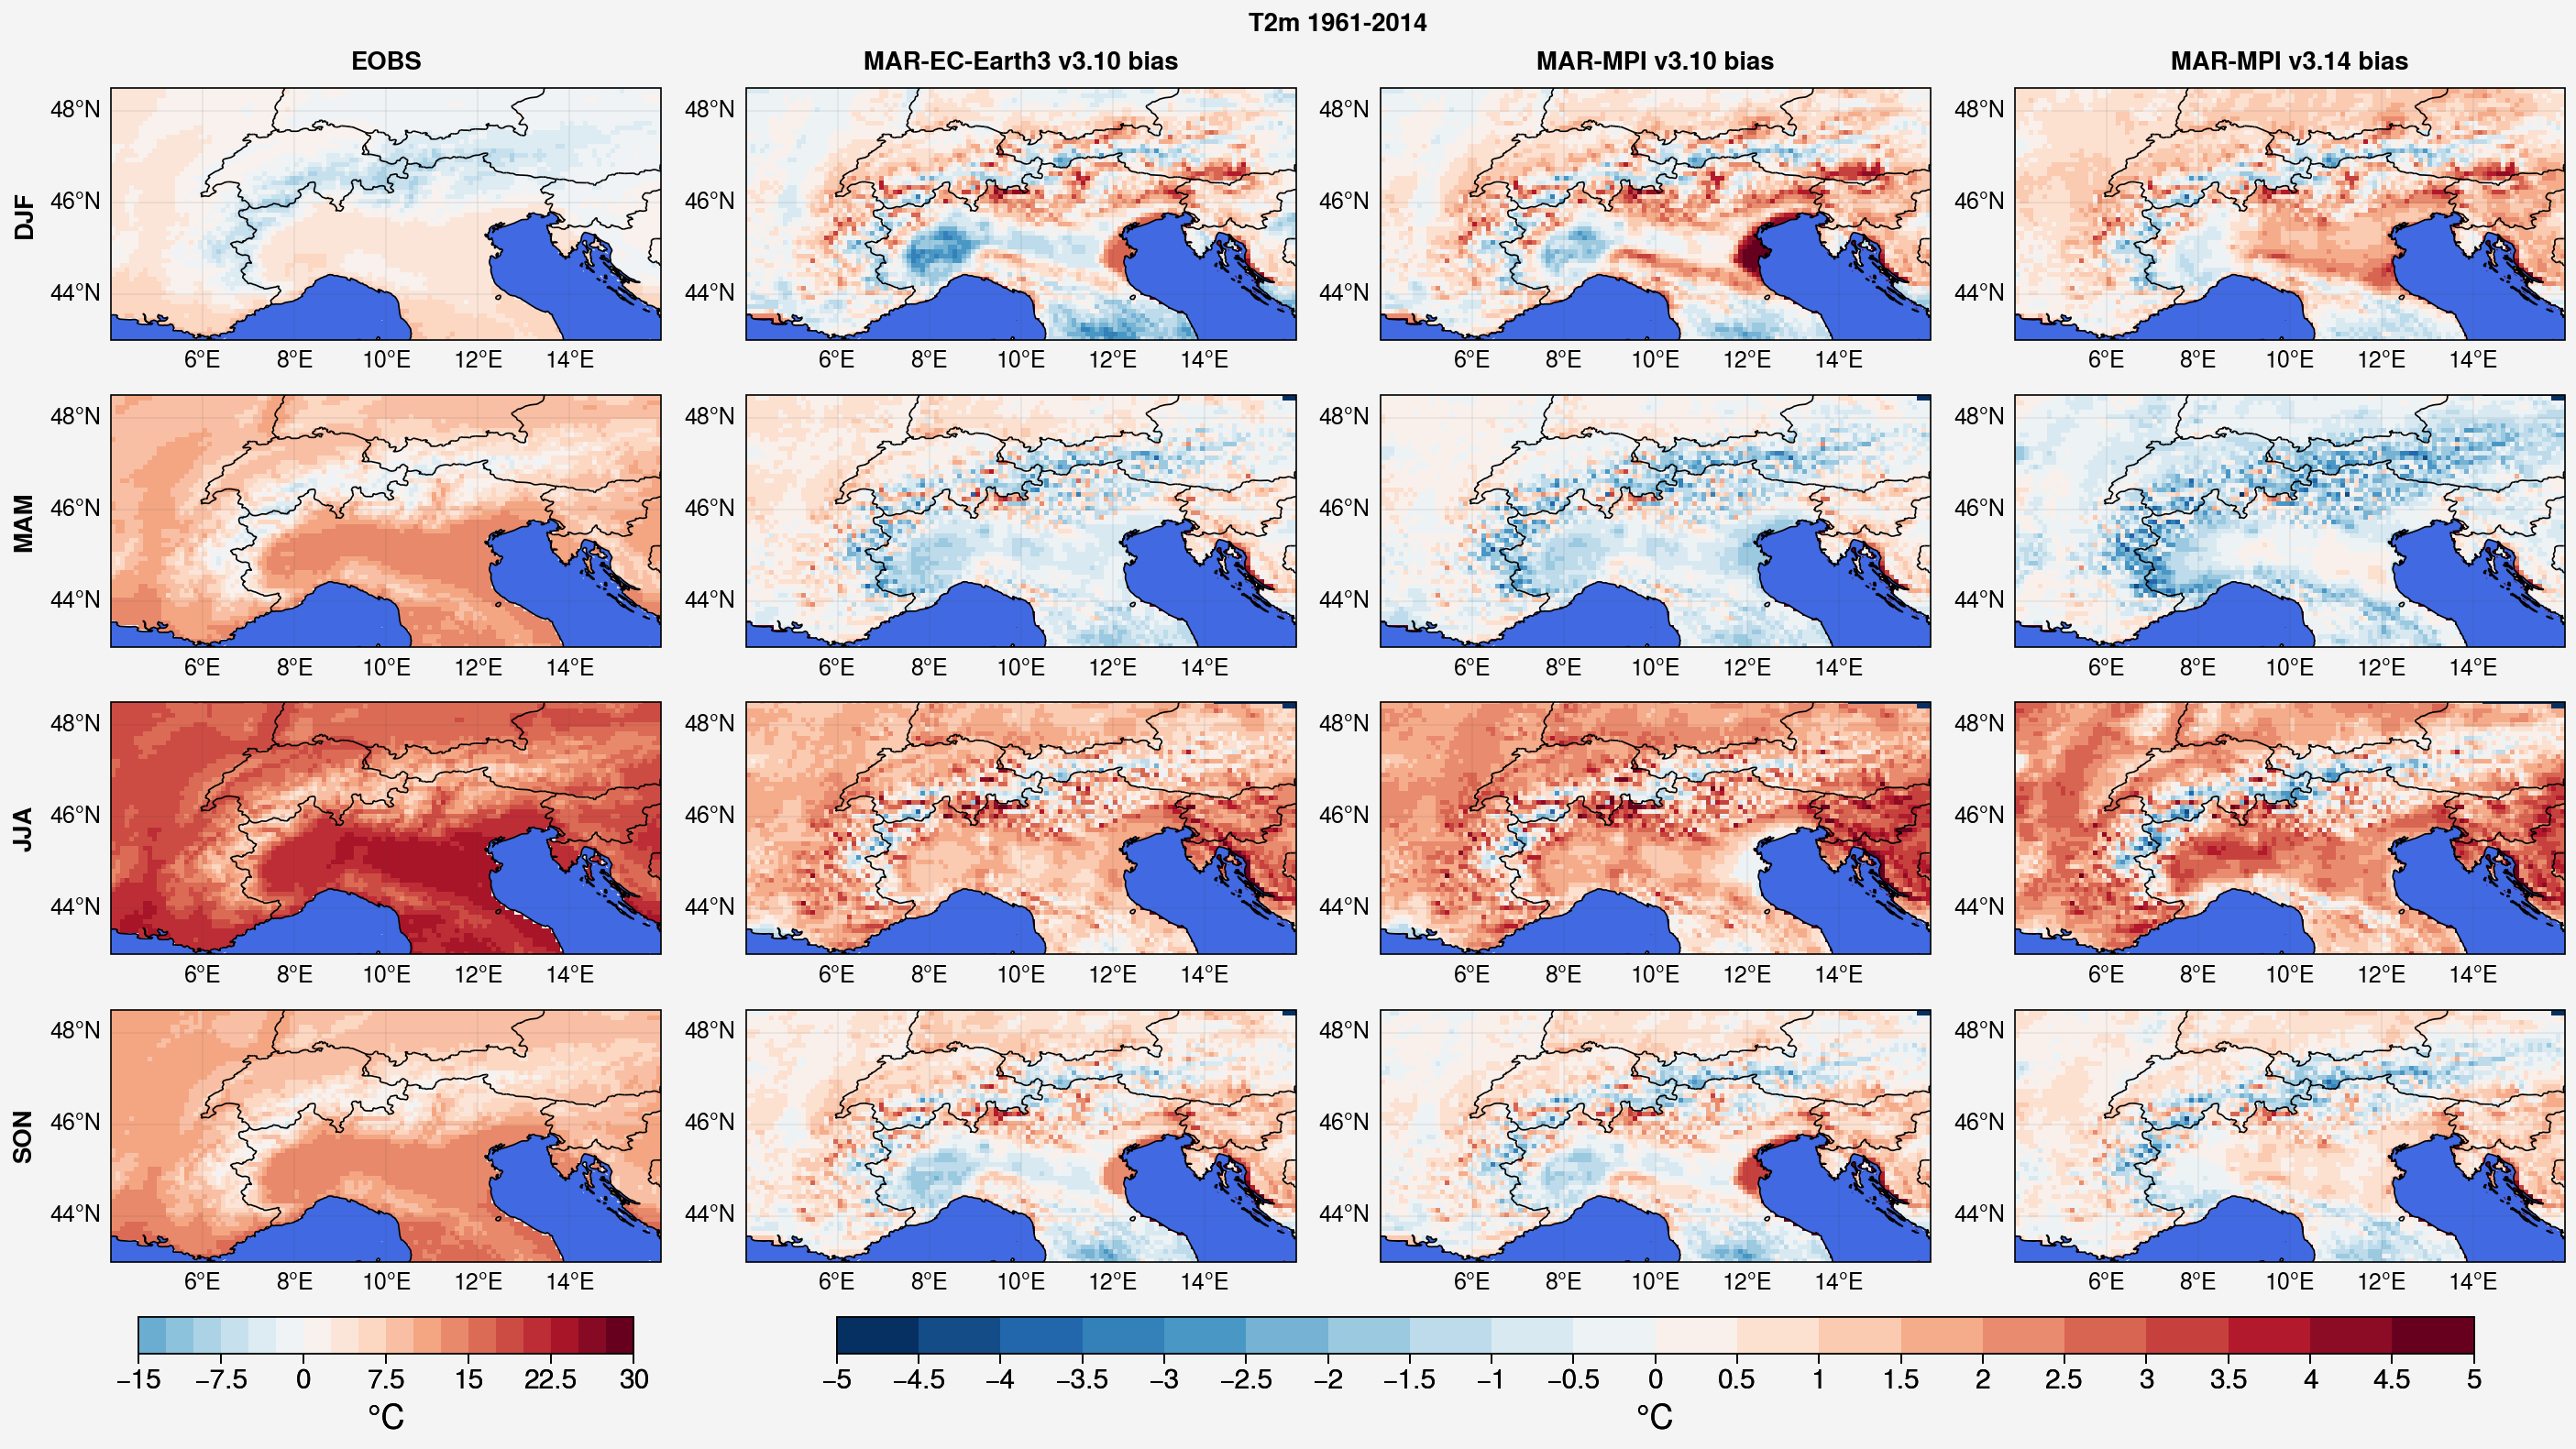

In [37]:
f, axs = pplt.subplots(proj='cyl', axwidth=3,axheight=1.5,ncols=4,nrows=4)

yr_start = 1961
yr_end = 2014

colmap = 'RdBu_r'
#levels_seas = [np.arange(-15,15,2.5),np.arange(-10,20,2.5),np.arange(-5,35,2.5),np.arange(-10,25,2.5)]
levels_seas = np.arange(-15,32.5,2.5)
levels_seas2 = np.arange(-5,5.5,0.5)

for seas in range(4):
    T_EOBS = ds_TG_EOBS_seas.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    m=axs[4*seas].pcolormesh(ds_TG_EOBS_seas.longitude, ds_TG_EOBS_seas.latitude, T_EOBS, levels=levels_seas,cmap=colmap)

    T_310_EC = ds_v310_EC_T_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    m2=axs[4*seas+1].pcolormesh(ds_TG_EOBS_seas.longitude, ds_TG_EOBS_seas.latitude, T_310_EC - T_EOBS, levels=levels_seas2,cmap=colmap)
    
    T_310 = ds_v310_T_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    m2=axs[4*seas+2].pcolormesh(ds_TG_EOBS_seas.longitude, ds_TG_EOBS_seas.latitude, T_310 - T_EOBS, levels=levels_seas2,cmap=colmap)
    
    T_314 = ds_v314_T_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    m2=axs[4*seas+3].pcolormesh(ds_TG_EOBS_seas.longitude, ds_TG_EOBS_seas.latitude, T_314 - T_EOBS, levels=levels_seas2,cmap=colmap)


f.colorbar(m,label= '°C',labelsize='x-large',ticklabelsize='large',loc='b',col=1,length=0.9)
f.colorbar(m2,label= '°C',labelsize='x-large',ticklabelsize='large',loc='b',cols=(2,4),length=0.9)

f.format(**normal_format)
f.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],rowlabels=['DJF','MAM','JJA','SON'],
         collabels=['EOBS','MAR-EC-Earth3 v3.10 bias','MAR-MPI v3.10 bias','MAR-MPI v3.14 bias'],suptitle='T2m 1961-2014')
# f.format(reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],rowlabels=['DJF','MAM','JJA','SON'],
#          collabels=['EOBS','MAR-EC-Earth3 v3.10 bias','MAR-MPI v3.10 bias','MAR-MPI v3.14 bias'],suptitle='T2m 1961-2014')


In [54]:
# Levels (altitude bands)
H=np.array(ds_elev_EOBS.elevation.sel(longitude=slice(5.04986,16.04986),latitude=slice(43.049861,48.049861)))

levels = [H<200, np.logical_and(H>=200,H<400), np.logical_and(H>=400,H<600), np.logical_and(H>=600,H<800),
          np.logical_and(H>=800,H<1000), np.logical_and(H>=1000,H<1200), np.logical_and(H>=1200,H<1400),
          np.logical_and(H>=1400,H<1600), np.logical_and(H>=1600,H<1800), np.logical_and(H>=1800,H<2000),
          np.logical_and(H>=2000,H<2200), np.logical_and(H>=2200,H<2400), np.logical_and(H>=2400,H<2600),
          np.logical_and(H>=2600,H<2800), H>=2800]#,
          #alps]

H_levels = [100,300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900]

In [55]:
n_levels=len(levels)
n_seas=4

TG_EOBS_seas_lev=np.full((n_seas,n_levels),np.nan)
v310_EC_T_regrid_lev=np.full((n_seas,n_levels),np.nan)
v310_T_regrid_lev=np.full((n_seas,n_levels),np.nan)
v314_T_regrid_lev=np.full((n_seas,n_levels),np.nan)

for seas in range(4):
    for j in range(n_levels):
        arr = ds_TG_EOBS_seas.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end)),longitude=slice(5.04986,16.04986),
                                                   latitude=slice(43.049861,48.049861)).mean(dim='Year')
        TG_EOBS_seas_lev[seas,j] = np.ma.masked_array(arr, mask=np.invert(levels[j])).reshape(arr.shape[0]*arr.shape[1]).mean()
        
        arr = ds_v310_EC_T_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end)),longitude=slice(5.04986,16.04986),
                                                   latitude=slice(43.049861,48.049861)).mean(dim='Year')
        v310_EC_T_regrid_lev[seas,j] = np.ma.masked_array(arr, mask=np.invert(levels[j])).reshape(arr.shape[0]*arr.shape[1]).mean()
        
        arr = ds_v310_T_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end)),longitude=slice(5.04986,16.04986),
                                                   latitude=slice(43.049861,48.049861)).mean(dim='Year')
        v310_T_regrid_lev[seas,j] = np.ma.masked_array(arr, mask=np.invert(levels[j])).reshape(arr.shape[0]*arr.shape[1]).mean()
        
        arr = ds_v314_T_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end)),longitude=slice(5.04986,16.04986),
                                                   latitude=slice(43.049861,48.049861)).mean(dim='Year')
        v314_T_regrid_lev[seas,j] = np.ma.masked_array(arr, mask=np.invert(levels[j])).reshape(arr.shape[0]*arr.shape[1]).mean()

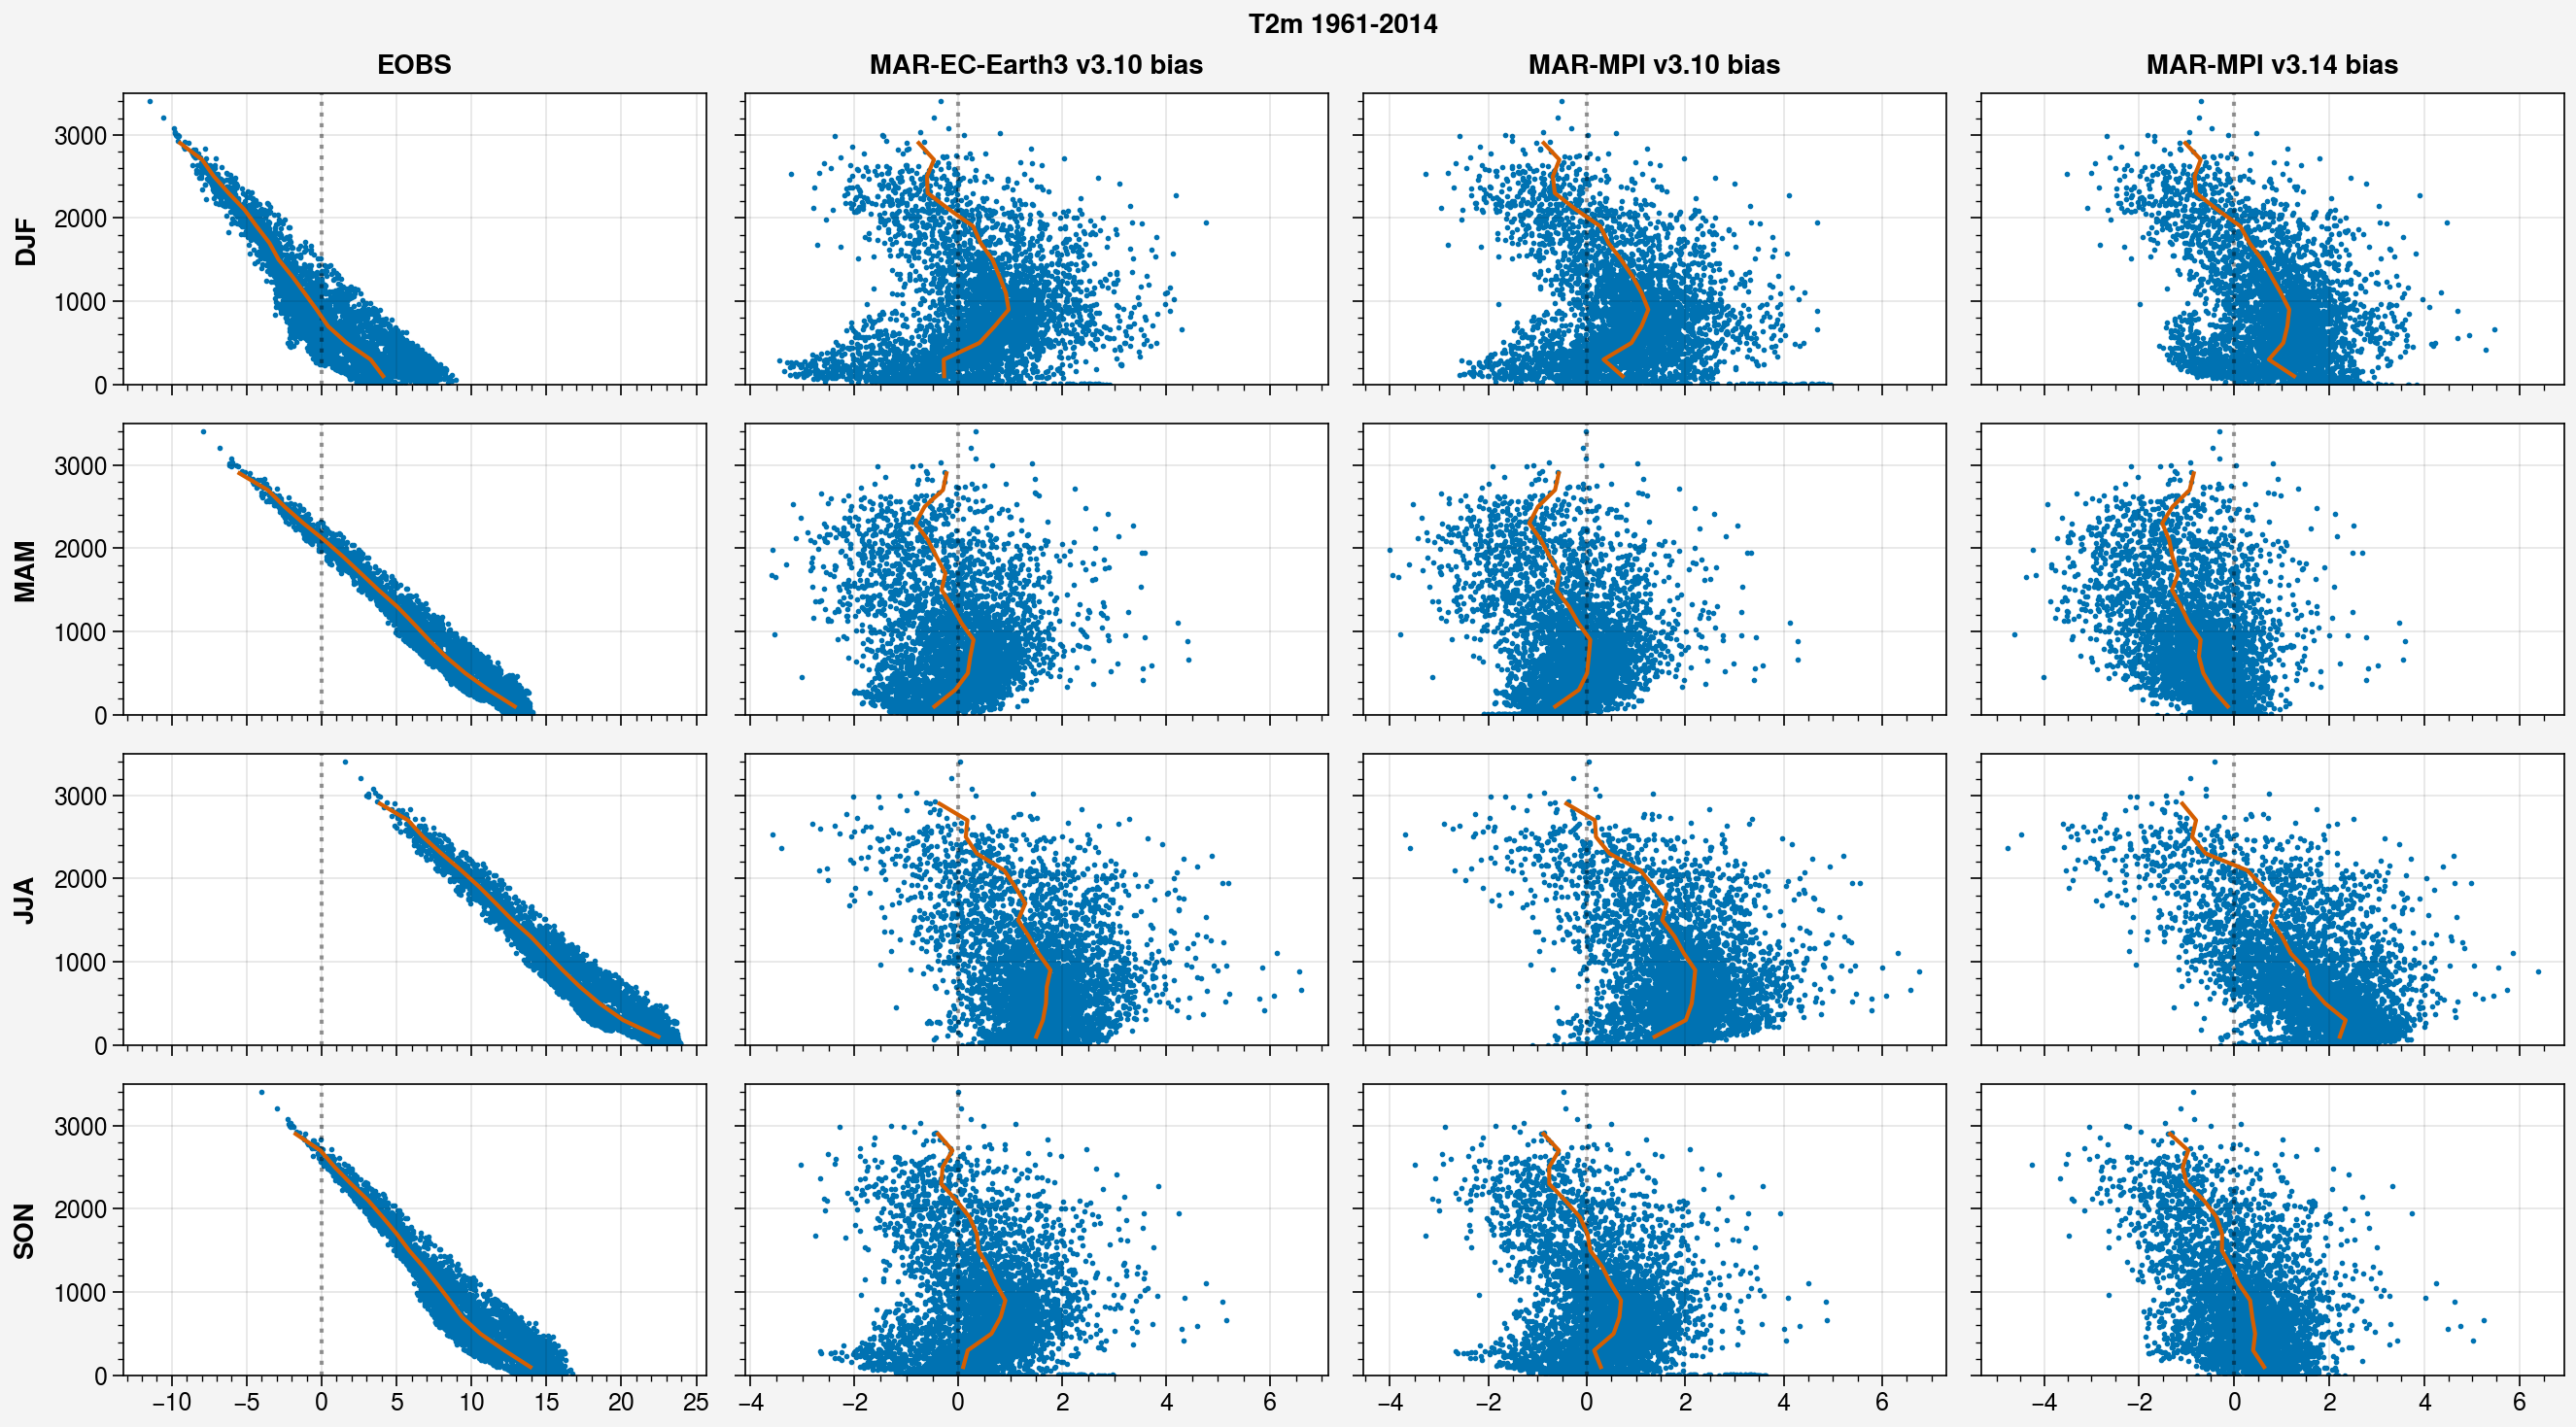

In [57]:
f, axs = pplt.subplots(axwidth=3,axheight=1.5,ncols=4,nrows=4)

yr_start = 1961
yr_end = 2014

#levels_seas = [np.arange(-15,15,2.5),np.arange(-10,20,2.5),np.arange(-5,35,2.5),np.arange(-10,25,2.5)]
levels_seas = np.arange(-15,32.5,2.5)
levels_seas2 = np.arange(-5,5.5,0.5)

for seas in range(4):
    T_EOBS = ds_TG_EOBS_seas.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end)),longitude=slice(5.04986,16.04986),
                                                   latitude=slice(43.049861,48.049861)).mean(dim='Year')
    axs[4*seas].scatter(np.array(T_EOBS).flatten(), np.array(ds_elev_EOBS.elevation.sel(longitude=slice(5.04986,16.04986),
                                                                                        latitude=slice(43.049861,48.049861))).flatten(),s=2)
    axs[4*seas].vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    axs[4*seas].plot(TG_EOBS_seas_lev[seas,:],H_levels)

    T_310_EC = ds_v310_EC_T_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    axs[4*seas+1].scatter(np.array(T_310_EC - T_EOBS).flatten(), np.array(ds_elev_EOBS.elevation.sel(longitude=slice(5.04986,16.04986),
                                                                                        latitude=slice(43.049861,48.049861))).flatten(),s=2)
    axs[4*seas+1].vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    axs[4*seas+1].plot(v310_EC_T_regrid_lev[seas,:] - TG_EOBS_seas_lev[seas,:],H_levels)

    T_310 = ds_v310_T_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    axs[4*seas+2].scatter(np.array(T_310 - T_EOBS).flatten(), np.array(ds_elev_EOBS.elevation.sel(longitude=slice(5.04986,16.04986),
                                                                                        latitude=slice(43.049861,48.049861))).flatten(),s=2)
    axs[4*seas+2].vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    axs[4*seas+2].plot(v310_T_regrid_lev[seas,:] - TG_EOBS_seas_lev[seas,:],H_levels)
    
    T_314 = ds_v314_T_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    axs[4*seas+3].scatter(np.array(T_314 - T_EOBS).flatten(), np.array(ds_elev_EOBS.elevation.sel(longitude=slice(5.04986,16.04986),
                                                                                        latitude=slice(43.049861,48.049861))).flatten(),s=2)
    axs[4*seas+3].vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    axs[4*seas+3].plot(v314_T_regrid_lev[seas,:] - TG_EOBS_seas_lev[seas,:],H_levels)


#f.format(**normal_format)
f.format(rowlabels=['DJF','MAM','JJA','SON'],
         collabels=['EOBS','MAR-EC-Earth3 v3.10 bias','MAR-MPI v3.10 bias','MAR-MPI v3.14 bias'],suptitle='T2m 1961-2014')


#### Precipitation

In [71]:
ds_v310_ = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds_TTz_MB_precip_1961_2015_seas.npy')

In [58]:
ds_APGD_seas_regrid = regridding_onto_MAR(ds_APGD_seas,ds_v310_EC.TTz.isel(ztqlev=0)[:,:,jmin:jmax,imin:imax])
ds_APGD_seas_regrid.shape

(38, 4, 91, 139)

In [59]:
ds_APGD_mask0 = ds_APGD_seas_regrid == 0

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

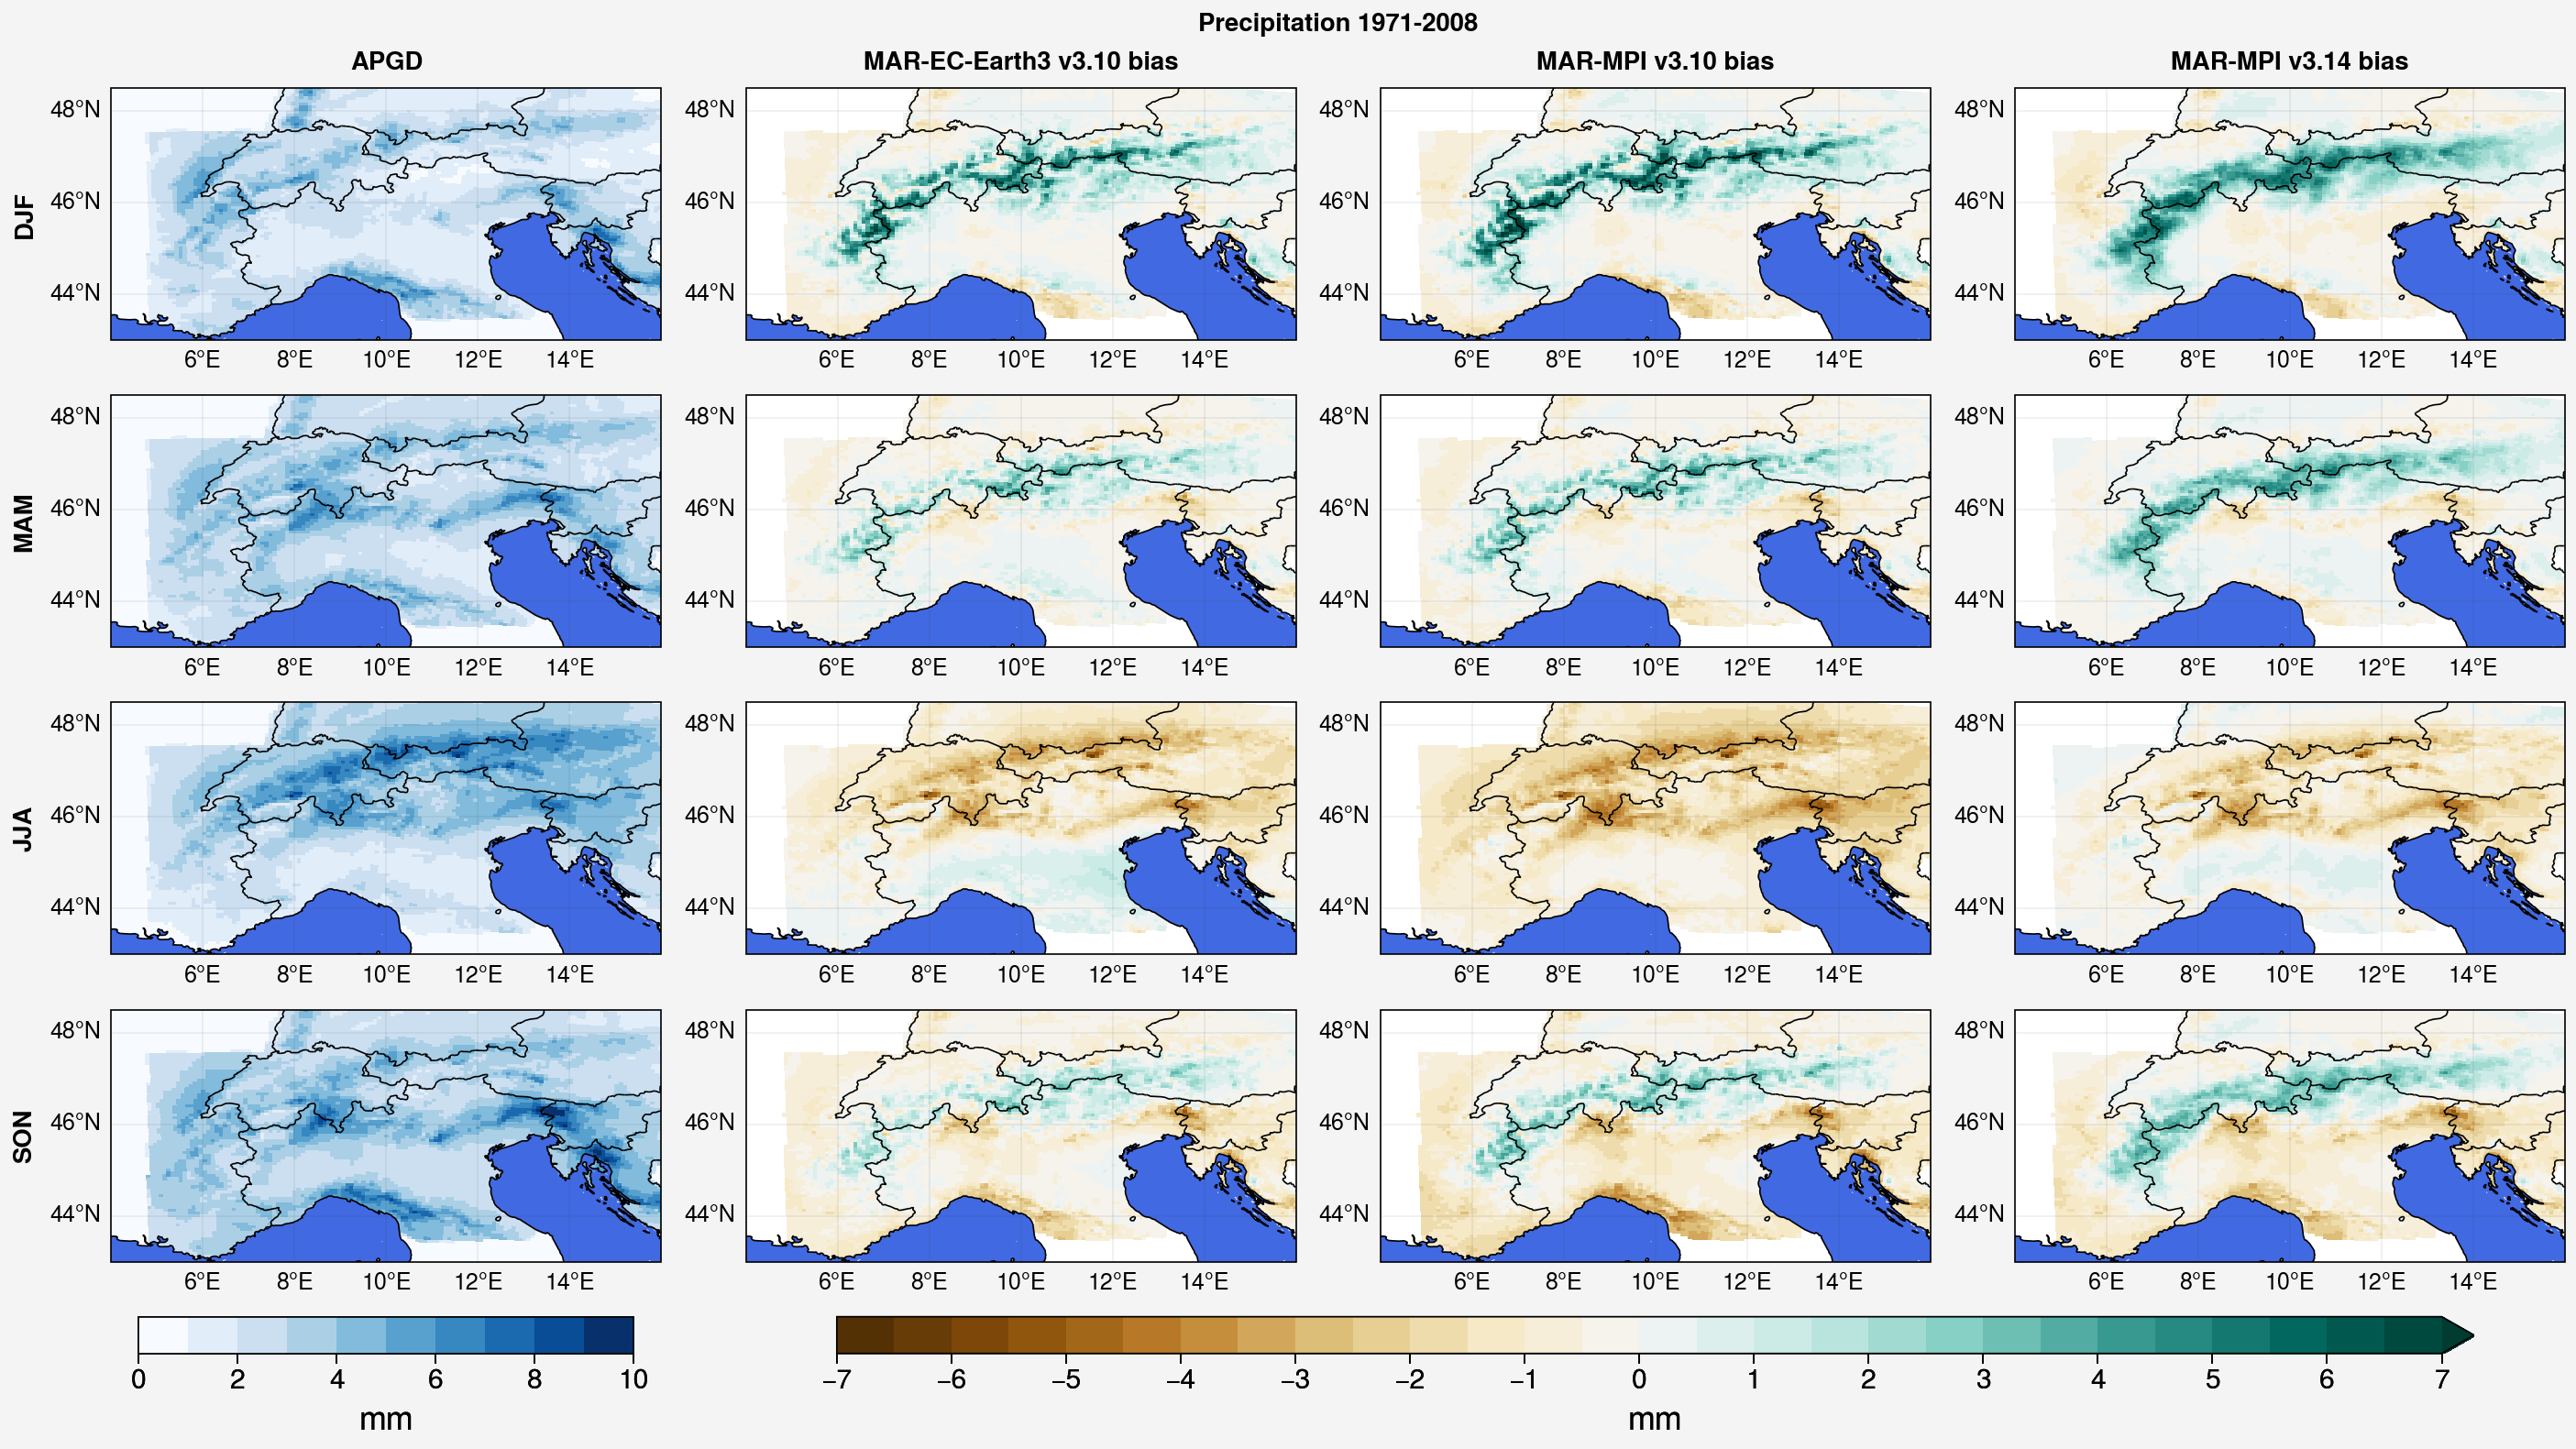

In [72]:
# Binary erosion : allows us to adapt the shape of MAR data to the APGD shape

from scipy.ndimage import binary_erosion

f, axs = pplt.subplots(proj='cyl', axwidth=3,axheight=1.5,ncols=4,nrows=4)

yr_start = 1971
yr_end = 2008

colmap = 'Blues'
colmap2 = 'BrBG'
#levels_seas = [np.arange(-15,15,2.5),np.arange(-10,20,2.5),np.arange(-5,35,2.5),np.arange(-10,25,2.5)]
levels_seas = np.arange(0,11.,1)
levels_seas2 = np.arange(-7,7.5,0.5)

for seas in range(4):
    T_APGD = ds_APGD_seas_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    T_APGD_mask = (~ds_APGD_mask0).isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    inner_mask = binary_erosion(T_APGD_mask, structure=np.ones((3,3)))
    
    m=axs[4*seas].pcolormesh(lon, lat, T_APGD, levels=levels_seas,cmap=colmap)

    T_310_EC = ds_v310_EC.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
    m2=axs[4*seas+1].pcolormesh(lon, lat, T_310_EC - T_APGD, levels=levels_seas2,cmap=colmap2)
    
    T_310 = ds_v310_.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
    m2=axs[4*seas+2].pcolormesh(lon, lat, T_310 - T_APGD, levels=levels_seas2,cmap=colmap2)
    
    T_314 = ds_v314_.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax]
    T_314 = T_314.assign_coords(x=T_310.x)
    T_314 = T_314.assign_coords(y=T_310.y).where(inner_mask)
    m2=axs[4*seas+3].pcolormesh(lon, lat, T_314 - T_APGD, levels=levels_seas2,cmap=colmap2,extend='max')


f.colorbar(m,label= 'mm',labelsize='x-large',ticklabelsize='large',loc='b',col=1,length=0.9)
f.colorbar(m2,label= 'mm',labelsize='x-large',ticklabelsize='large',loc='b',cols=(2,4),length=0.9)

f.format(**normal_format)
f.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],rowlabels=['DJF','MAM','JJA','SON'],
         collabels=['APGD','MAR-EC-Earth3 v3.10 bias','MAR-MPI v3.10 bias','MAR-MPI v3.14 bias'],suptitle='Precipitation 1971-2008')


/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

830.8143144200213
712.2168371558212
762.6034343045492
950.8013028932307
777.3927920589559
782.2239925059351
1689.6097892421228
819.8797427901644
866.841950470113
961.8763974643097
656.5360986403499
851.2596556102482


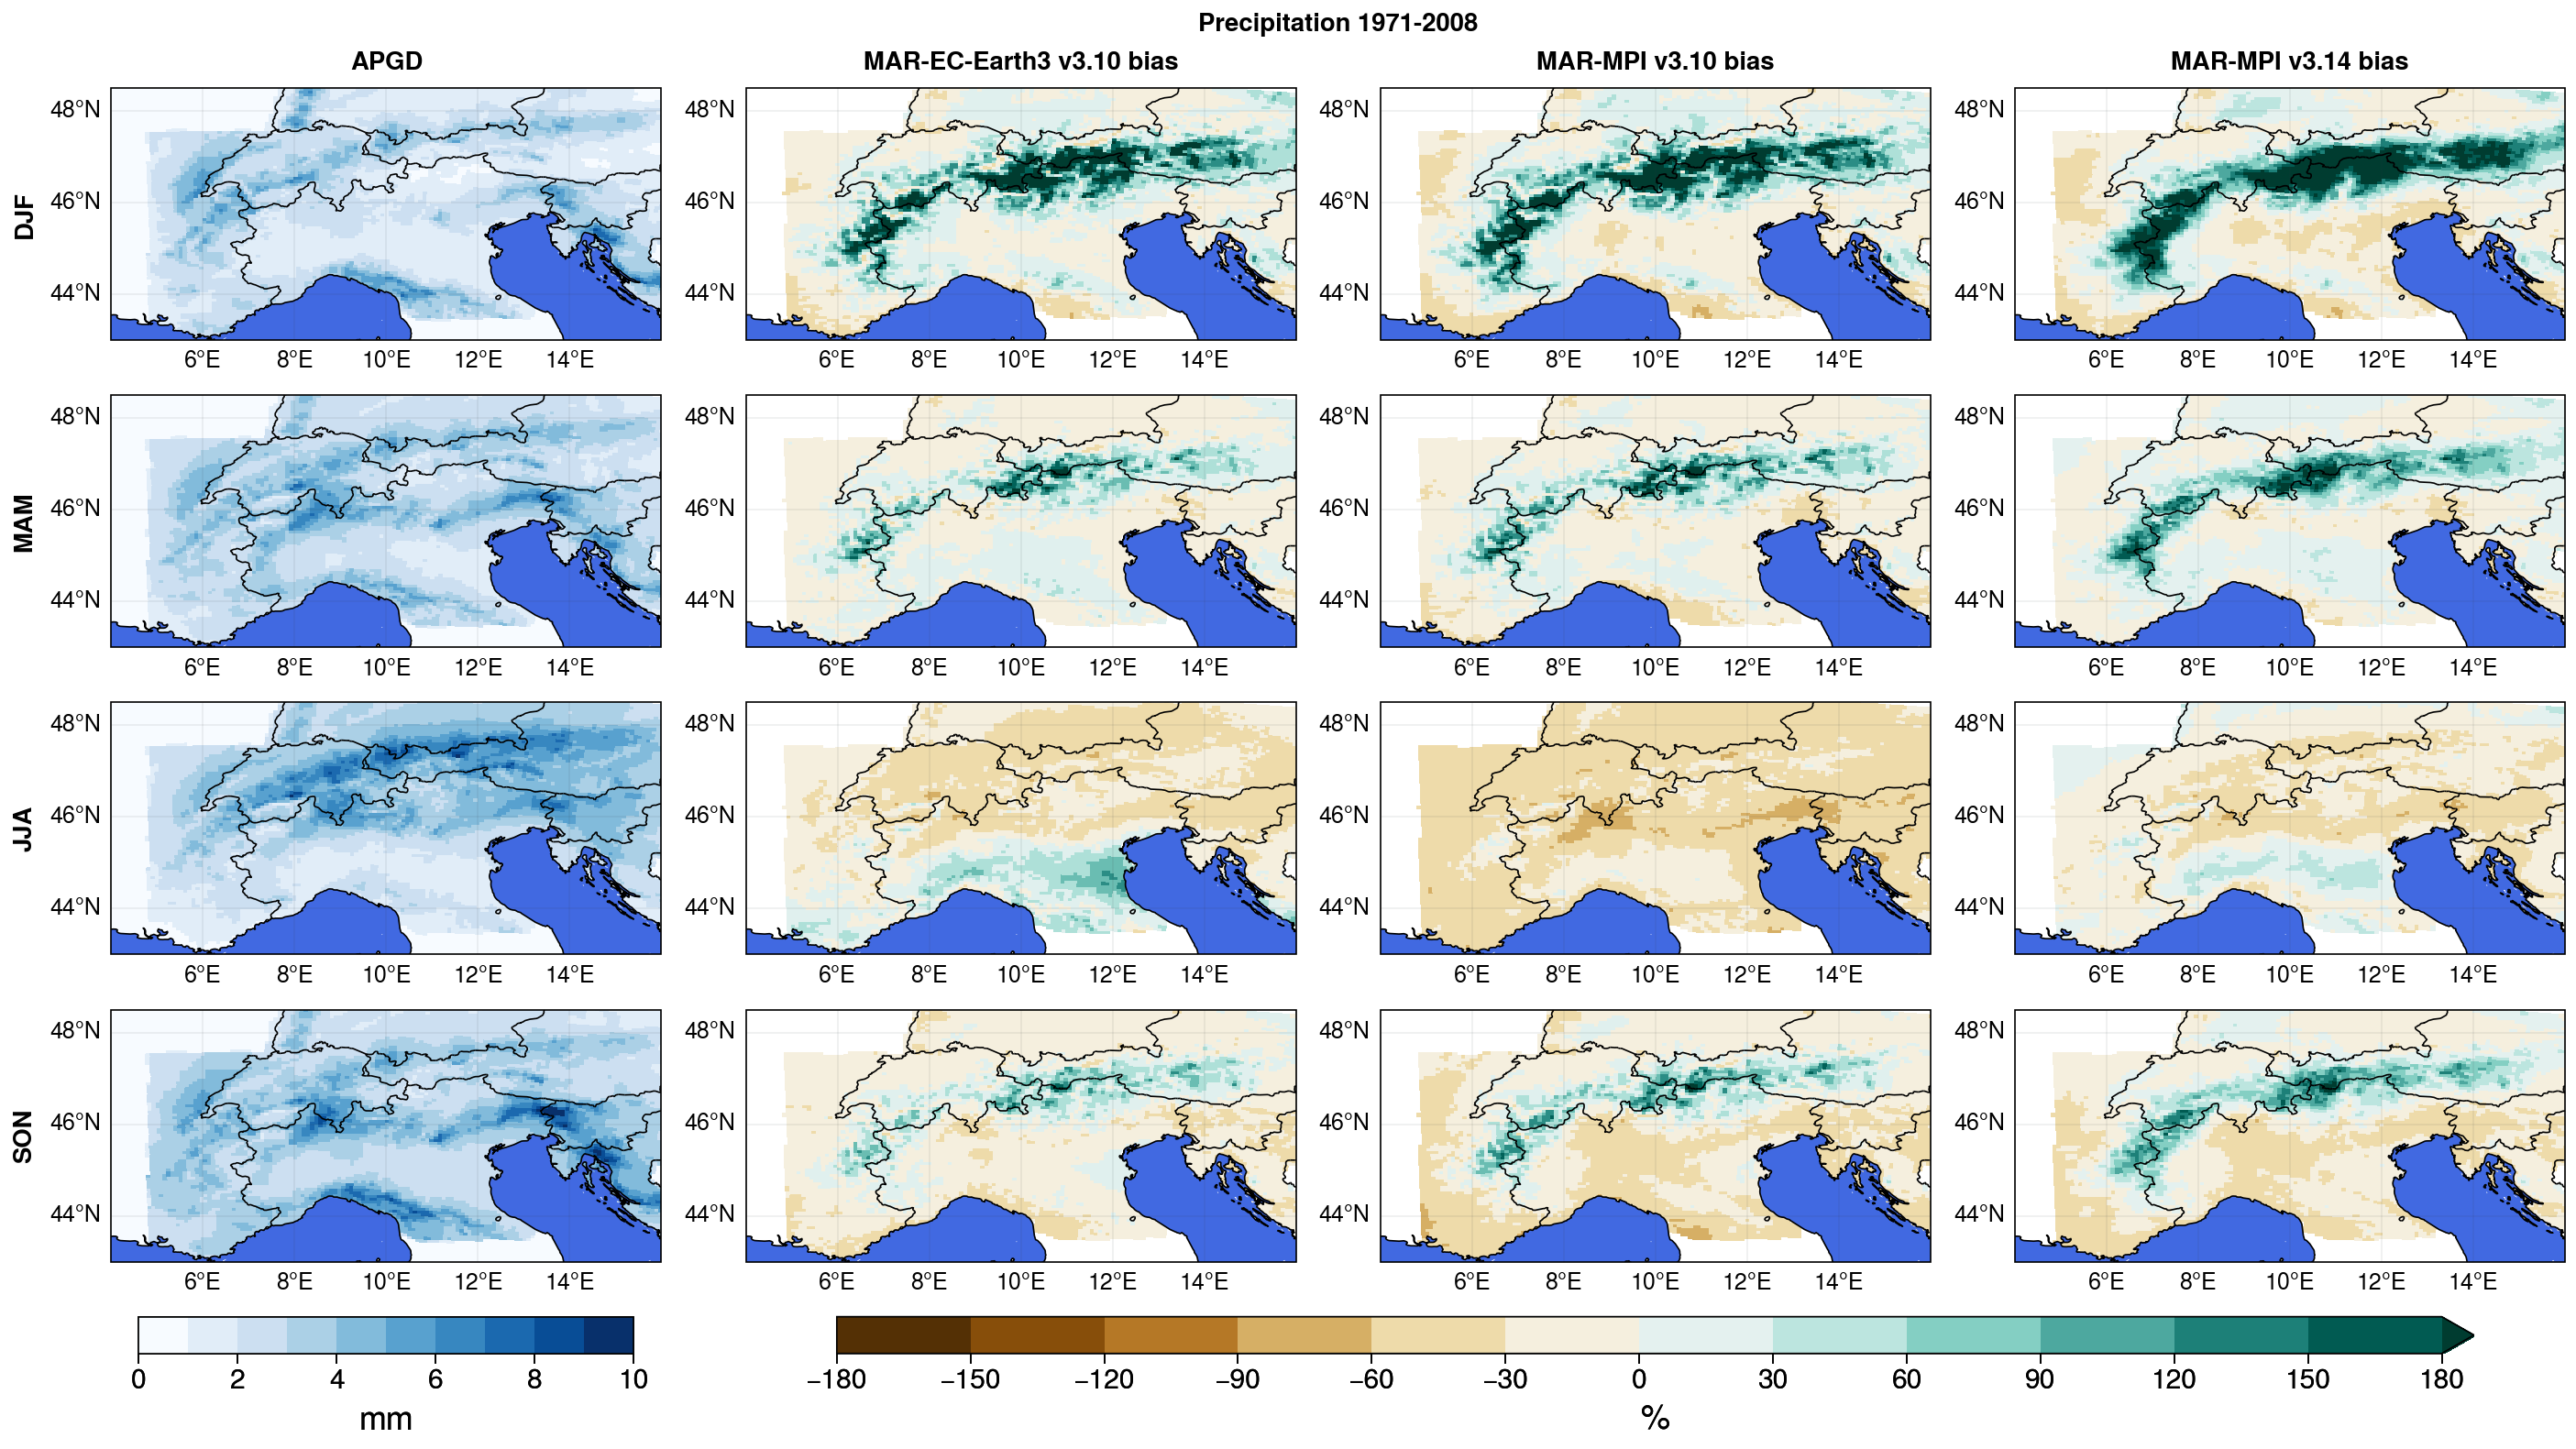

In [74]:
from scipy.ndimage import binary_erosion

pplt.rc['figure.facecolor'] = 'white'


f, axs = pplt.subplots(proj='cyl', axwidth=3,axheight=1.5,ncols=4,nrows=4)

yr_start = 1971
yr_end = 2008

colmap = 'Blues'
colmap2 = 'BrBG'
#levels_seas = [np.arange(-15,15,2.5),np.arange(-10,20,2.5),np.arange(-5,35,2.5),np.arange(-10,25,2.5)]
levels_seas = np.arange(0,11.,1)
levels_seas2 = np.arange(-180,210,30)

for seas in range(4):
    T_APGD = ds_APGD_seas_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    T_APGD_mask = (~ds_APGD_mask0).isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    # Erode the mask — this removes the outermost layer (edges)
    inner_mask = binary_erosion(T_APGD_mask, structure=np.ones((3,3)))
    
    m=axs[4*seas].pcolormesh(lon, lat, T_APGD, levels=levels_seas,cmap=colmap)

    T_310_EC = ds_v310_EC.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
    da_percent = (T_310_EC - T_APGD)/T_APGD*100
    #da_percent = da_percent.where(da_percent < 1500, 0).where(inner_mask)
    m2=axs[4*seas+1].pcolormesh(lon, lat, da_percent, levels=levels_seas2,cmap=colmap2)
    print(da_percent.max(skipna=True).values)
    
    T_310 = ds_v310_.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
    da_percent = (T_310 - T_APGD)/T_APGD*100
    m2=axs[4*seas+2].pcolormesh(lon, lat, (T_310 - T_APGD)/T_APGD*100, levels=levels_seas2,cmap=colmap2)
    print(da_percent.max(skipna=True).values)
    
    T_314 = ds_v314_.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax]
    T_314 = T_314.assign_coords(x=T_310.x)
    T_314 = T_314.assign_coords(y=T_310.y).where(inner_mask)
    da_percent = (T_314 - T_APGD)/T_APGD*100
    m2=axs[4*seas+3].pcolormesh(lon, lat, (T_314 - T_APGD)/T_APGD*100, levels=levels_seas2,cmap=colmap2,extend='max')
    print(da_percent.max(skipna=True).values)


f.colorbar(m,label= 'mm',labelsize='x-large',ticklabelsize='large',loc='b',col=1,length=0.9)
f.colorbar(m2,label= '%',labelsize='x-large',ticklabelsize='large',loc='b',cols=(2,4),length=0.9)

f.format(**normal_format)
f.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],rowlabels=['DJF','MAM','JJA','SON'],
         collabels=['APGD','MAR-EC-Earth3 v3.10 bias','MAR-MPI v3.10 bias','MAR-MPI v3.14 bias'],suptitle='Precipitation 1971-2008')


In [76]:
# Levels (altitude bands)
H = np.array(ds.SH[jmin:jmax,imin:imax])

levels = [H<200, np.logical_and(H>=200,H<400), np.logical_and(H>=400,H<600), np.logical_and(H>=600,H<800),
          np.logical_and(H>=800,H<1000), np.logical_and(H>=1000,H<1200), np.logical_and(H>=1200,H<1400),
          np.logical_and(H>=1400,H<1600), np.logical_and(H>=1600,H<1800), np.logical_and(H>=1800,H<2000),
          np.logical_and(H>=2000,H<2200), np.logical_and(H>=2200,H<2400), np.logical_and(H>=2400,H<2600),
          np.logical_and(H>=2600,H<2800), H>=2800]#,
          #alps]

H_levels = [100,300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900]

In [86]:
n_levels=len(levels)
n_seas=4

APGD_seas_regrid_lev=np.full((n_seas,n_levels),np.nan)
v310_EC_pr_lev=np.full((n_seas,n_levels),np.nan)
v310_pr_lev=np.full((n_seas,n_levels),np.nan)
v314_pr_lev=np.full((n_seas,n_levels),np.nan)

for seas in range(4):
    T_APGD = ds_APGD_seas_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    T_APGD_mask = (~ds_APGD_mask0).isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    # Erode the mask — this removes the outermost layer (edges)
    inner_mask = binary_erosion(T_APGD_mask, structure=np.ones((3,3)))
    
    for j in range(n_levels):
        arr = ds_APGD_seas_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
        APGD_seas_regrid_lev[seas,j] = np.ma.masked_array(arr, mask=np.invert(levels[j])).reshape(arr.shape[0]*arr.shape[1]).mean()
        
        arr = ds_v310_EC.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
        mask_arr = np.ma.masked_array(arr, mask=np.invert(levels[j])).reshape(arr.shape[0]*arr.shape[1])
        v310_EC_pr_lev[seas,j] = mask_arr[~np.isnan(mask_arr)].mean()
        
        arr = ds_v310_.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
        v310_pr_lev[seas,j] = np.ma.masked_array(arr, mask=np.invert(levels[j])).reshape(arr.shape[0]*arr.shape[1]).mean()
        
        arr = ds_v314_.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
        v314_pr_lev[seas,j] = np.ma.masked_array(arr, mask=np.invert(levels[j])).reshape(arr.shape[0]*arr.shape[1]).mean()

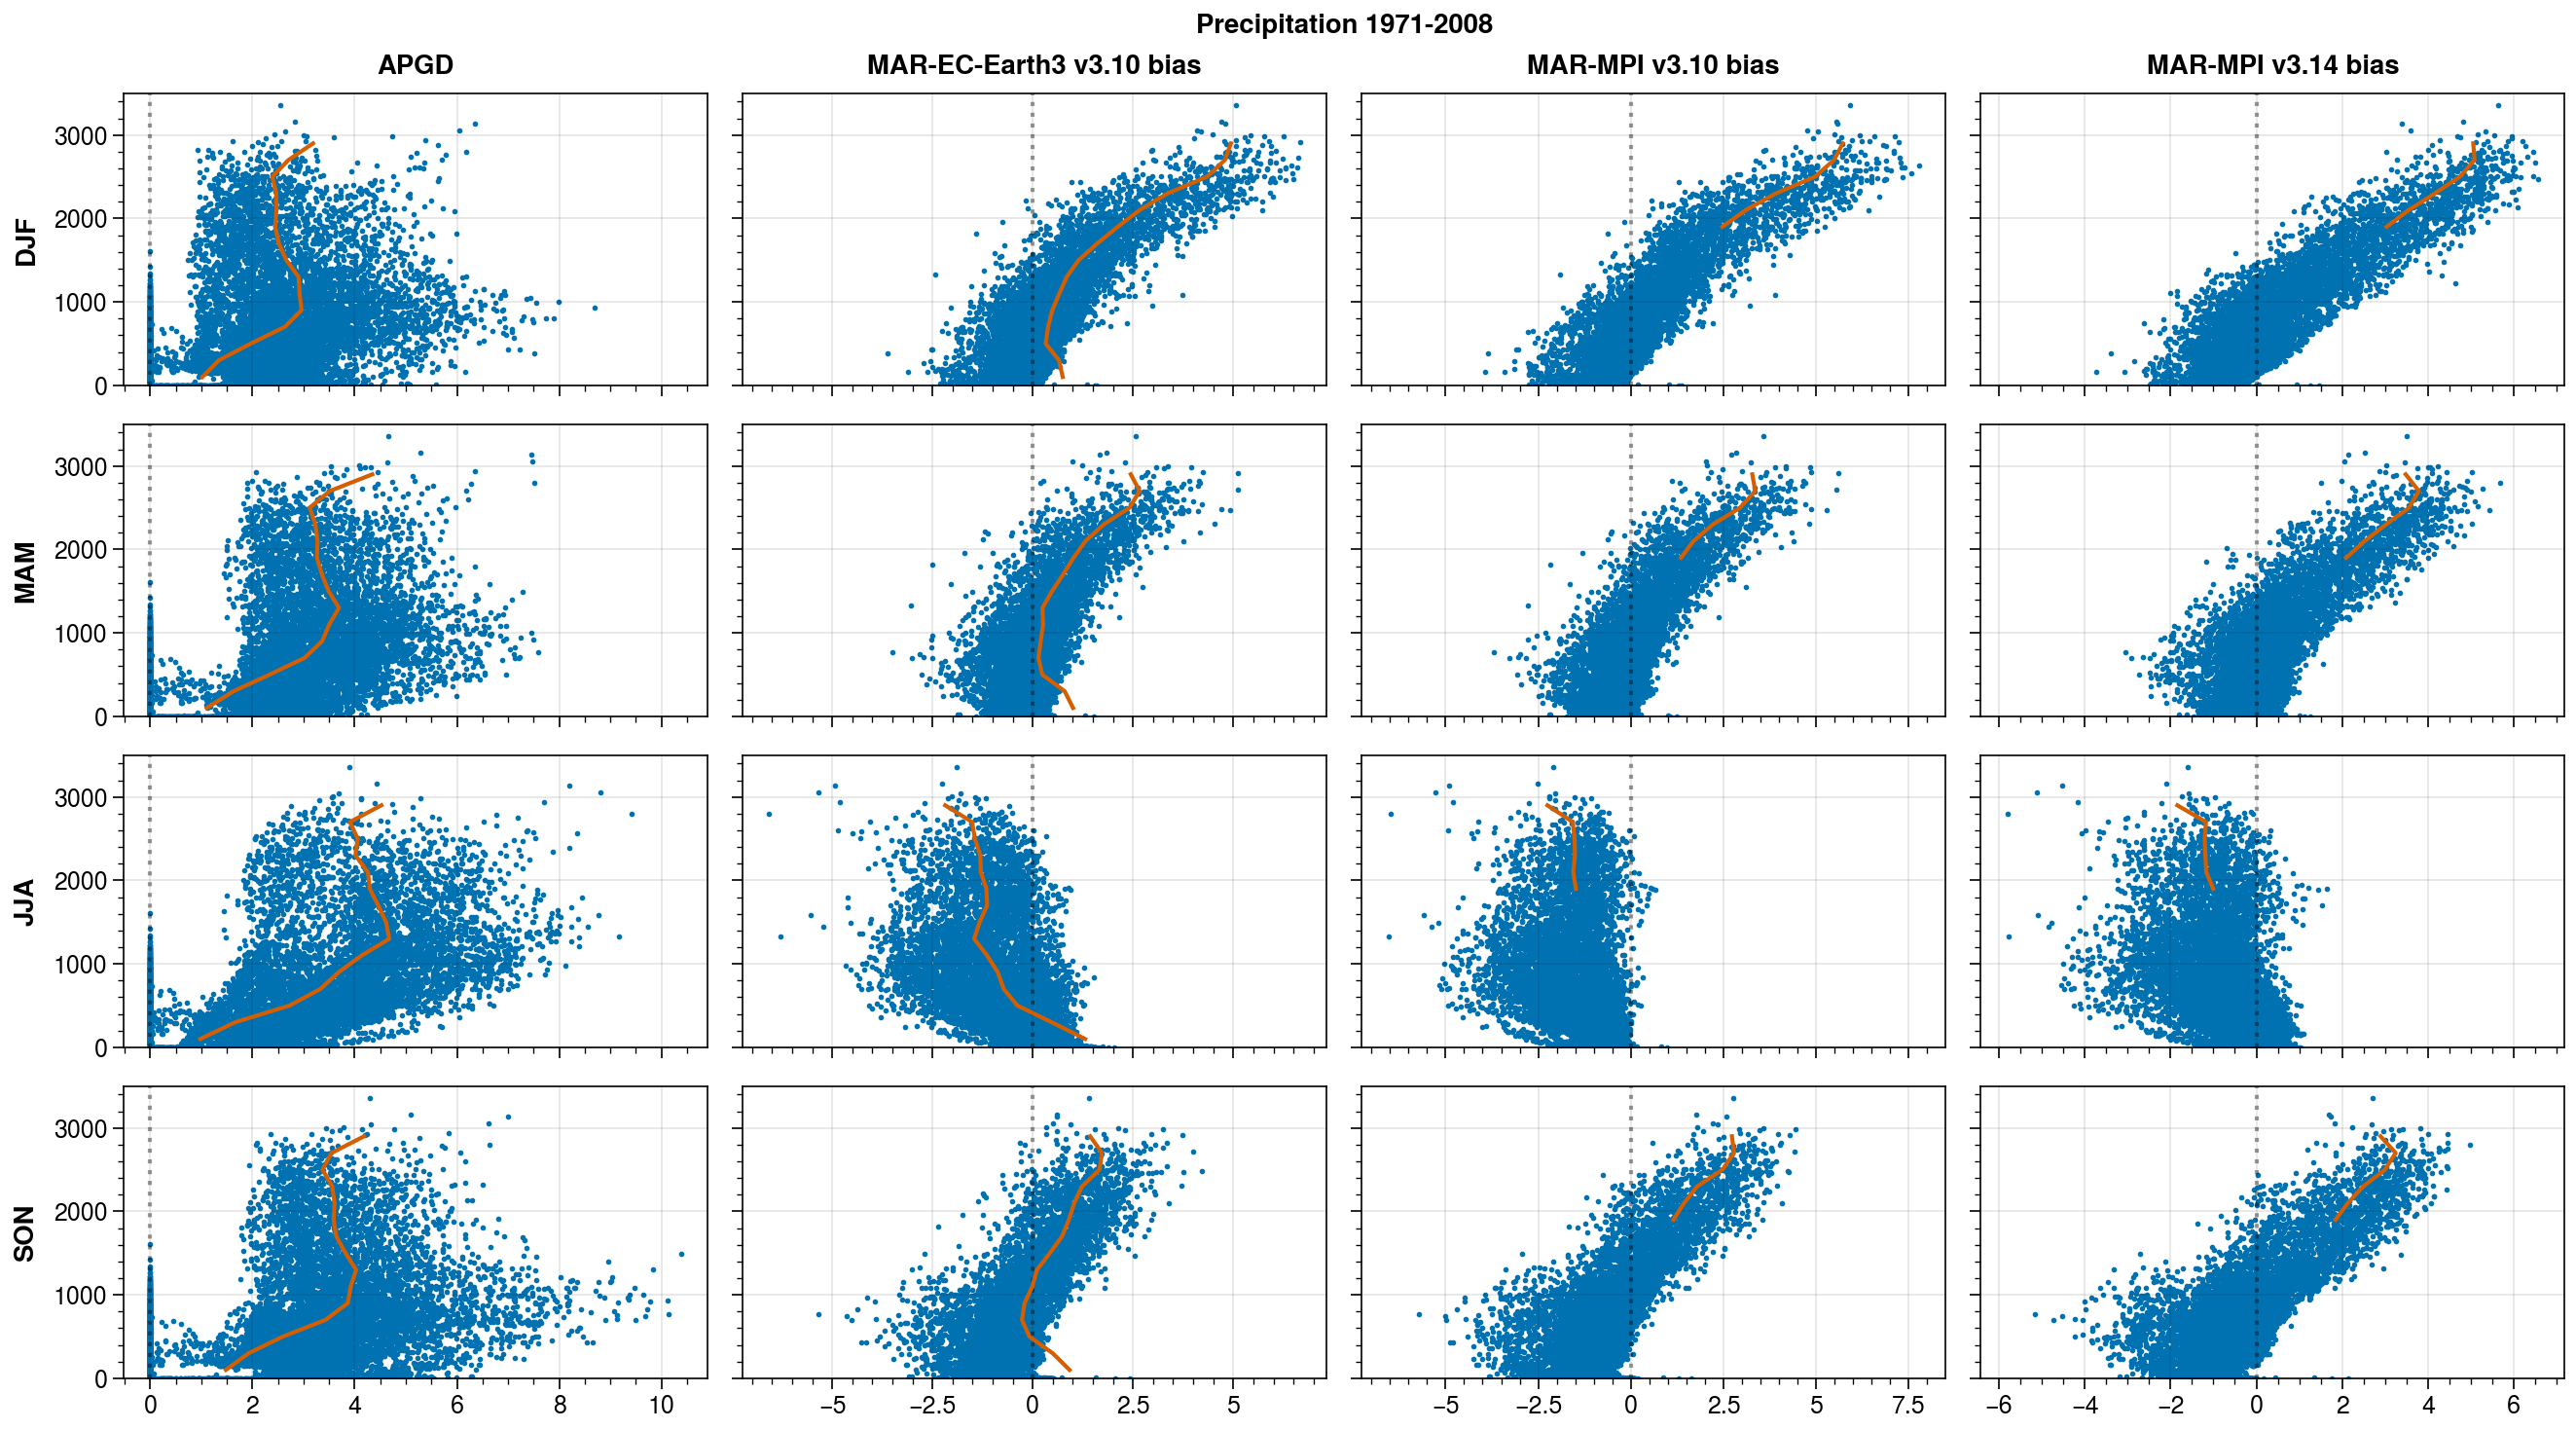

In [87]:
f, axs = pplt.subplots(axwidth=3,axheight=1.5,ncols=4,nrows=4)

yr_start = 1971
yr_end = 2008

for seas in range(4):
    T_APGD = ds_APGD_seas_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    T_APGD_mask = (~ds_APGD_mask0).isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')
    # Erode the mask — this removes the outermost layer (edges)
    inner_mask = binary_erosion(T_APGD_mask, structure=np.ones((3,3)))

    axs[4*seas].scatter(np.array(ds_APGD_seas_regrid.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')).flatten(),
                        H.flatten(),s=2)
    axs[4*seas].vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    axs[4*seas].plot(APGD_seas_regrid_lev[seas,:],H_levels)

    T_310_EC = ds_v310_EC.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
    axs[4*seas+1].scatter(np.array(T_310_EC - T_APGD).flatten(), H.flatten(),s=2)
    axs[4*seas+1].vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    axs[4*seas+1].plot(v310_EC_pr_lev[seas,:] - APGD_seas_regrid_lev[seas,:],H_levels)

    T_310 = ds_v310_.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
    axs[4*seas+2].scatter(np.array(T_310 - T_APGD).flatten(), H.flatten(),s=2)
    axs[4*seas+2].vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    axs[4*seas+2].plot(v310_pr_lev[seas,:] - APGD_seas_regrid_lev[seas,:],H_levels)
    
    T_314 = ds_v314_.precip.isel(season=seas).sel(Year=slice(str(yr_start),str(yr_end))).mean(dim='Year')[jmin:jmax,imin:imax].where(inner_mask)
    T_314 = T_314.assign_coords(x=T_310.x)
    T_314 = T_314.assign_coords(y=T_310.y).where(inner_mask)
    axs[4*seas+3].scatter(np.array(T_314 - T_APGD).flatten(), H.flatten(),s=2)
    axs[4*seas+3].vlines(0,0,3500,c='k',linestyle=':',alpha=0.4)
    axs[4*seas+3].plot(v314_pr_lev[seas,:] - APGD_seas_regrid_lev[seas,:],H_levels)


#f.format(**normal_format)
f.format(rowlabels=['DJF','MAM','JJA','SON'],
         collabels=['APGD','MAR-EC-Earth3 v3.10 bias','MAR-MPI v3.10 bias','MAR-MPI v3.14 bias'],suptitle='Precipitation 1971-2008')


In [81]:
np.array(T_314 - T_APGD).shape

(68, 97)

### Snow cover days
For CCI SNOW, the data can be procured through the following link : https://catalogue.ceda.ac.uk/uuid/3f034f4a08854eb59d58e1fa92d207b6/

#### Making seasonal datasets

The following file was made with notebook Snow_mountain_trends_change_threshold, by choosing scf_threshold = 50 (meaning a pixel is considered to be snowy if at least 50% of its area is covered in snow).

In [12]:
ds_CCI_SNOW_thresh50 = xr.open_dataset('/bettik/castelli/data/saved_data_CCI_SNOW/Alpine_snow_nbdays_threshold50.nc')


In [13]:
ds_CCI_SNOW_thresh50_seas = ds_CCI_SNOW_thresh50.groupby("time.season").sum(dim="time")

ds_CCI_SNOW_thresh50_seas

<xarray.Dataset>
Dimensions:         (lon: 240, lat: 100, season: 4)
Coordinates:
  * lon             (lon) float64 5.025 5.075 5.125 5.175 ... 16.88 16.93 16.98
  * lat             (lat) float64 43.02 43.08 43.12 43.17 ... 47.88 47.92 47.98
    reference_time  datetime64[ns] 1982-01-01
  * season          (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    nbdays          (season, lat, lon) float64 0.0 0.0 0.0 ... 27.0 28.0 26.0
    nbdays2         (season, lat, lon) float64 0.0 0.0 0.0 ... 25.0 25.0 26.0
    nbdays_filled   (season, lat, lon) float64 0.0 0.0 0.0 ... 28.75 32.5 28.0
Attributes:
    documentation:  Computing snow cover duration from CCI_SNOW snow cover fr...

In [22]:
ds_CCI_SNOW_thresh50_seas_1982_2014 = ds_CCI_SNOW_thresh50.sel(time=ds_CCI_SNOW_thresh50.time.dt.year <= 2014).groupby("time.season").sum(dim="time")

In [20]:
ds_CCI_SNOW_thresh50_seas.to_netcdf('/bettik/castelli/data/saved_data_CCI_SNOW/ds_CCI_snow_nbdays_seas_thresh50.nc')

In [26]:
ds_CCI_SNOW_thresh50_seas_1982_2014.to_netcdf('/bettik/castelli/data/saved_data_CCI_SNOW/ds_CCI_snow_nbdays_seas_thresh50_1982_2014.nc')

In [56]:
ds_v310_EC_snowdays = make_ds_snowdays(path = '/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST',simcode='e',
                                       first_year=1982,last_year=2014,threshold_snow = 10)

1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 

In [64]:
ds_v310_EC_snowdays.to_netcdf('/bettik/castelli/data/saved_data_MAR_ECEarth3/HIST/ds_snowdays_1982_2014_thresh10_month.npy')

In [65]:
ds_v310_snowdays = make_ds_snowdays(path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST',simcode='y',
                                       first_year=1982,last_year=2014,threshold_snow = 10)

1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 

In [67]:
ds_v310_snowdays.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds_snowdays_1982_2014_thresh10_month.npy')

In [26]:
ds_v314_snowdays = make_ds_snowdays(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/HIST/ICE.MPI-ESM_HIST',simcode='n',
                                       first_year=1982,last_year=2014,threshold_snow = 10)

1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 

In [27]:
ds_v314_snowdays.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds314_snowdays_1982_2014_thresh10_month.npy')

This time with 50mmWe of snow threshold :

In [65]:
ds_v310_EC_snowdays = make_ds_snowdays(path = '/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST',simcode='e',
                                       first_year=1982,last_year=2014,threshold_snow = 50)

1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 

In [66]:
ds_v310_EC_snowdays.to_netcdf('/bettik/castelli/data/saved_data_MAR_ECEarth3/HIST/ds_snowdays_1982_2014_thresh50_month.npy')

In [67]:
ds_v310_snowdays = make_ds_snowdays(path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST',simcode='y',
                                       first_year=1982,last_year=2014,threshold_snow = 50)

1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 

In [68]:
ds_v310_snowdays.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds_snowdays_1982_2014_thresh50_month.npy')

In [69]:
ds_v314_snowdays = make_ds_snowdays(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/HIST/ICE.MPI-ESM_HIST',simcode='n',
                                       first_year=1982,last_year=2014,threshold_snow = 50)

1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 

In [70]:
ds_v314_snowdays.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds314_snowdays_1982_2014_thresh50_month.npy')

#### Snow cover days results

In [16]:
ds_CCI_SNOW_thresh50_seas_1982_2014 = xr.open_dataset('/bettik/castelli/data/saved_data_CCI_SNOW/ds_CCI_snow_nbdays_seas_thresh50_1982_2014.nc')

Loading the files counting snow days when there is at least 10 mmWe snow on the ground :

In [17]:
ds_v310_EC_snowdays = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_ECEarth3/HIST/ds_snowdays_1982_2014_thresh10_month.npy')

In [18]:
ds_v310_snowdays = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds_snowdays_1982_2014_thresh10_month.npy')

In [19]:
ds_v314_snowdays = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds314_snowdays_1982_2014_thresh10_month.npy')

Loading the files counting snow days when there is at least 50 mmWe snow on the ground :

In [20]:
ds_v310_EC_snowdays = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_ECEarth3/HIST/ds_snowdays_1982_2014_thresh50_month.npy')
ds_v310_snowdays = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds_snowdays_1982_2014_thresh50_month.npy')
ds_v314_snowdays = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds314_snowdays_1982_2014_thresh50_month.npy')

In [21]:
ds_CCI_SNOW_seas_thresh50_regrid = regridding_onto_MAR(ds_CCI_SNOW_thresh50_seas_1982_2014,ds_v310_EC_snowdays).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],
                                                                                                                  dims=['season']))

In [23]:
ds_v310_EC_snowdays_seas = ds_v310_EC_snowdays.groupby("time.season").sum(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

ds_v310_EC_snowdays_seas = ds_v310_EC_snowdays_seas['__xarray_dataarray_variable__'].where(ds_CCI_SNOW_seas_thresh50_regrid.nbdays_filled.notnull())

In [24]:
ds_v310_snowdays_seas = ds_v310_snowdays.groupby("time.season").sum(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

ds_v310_snowdays_seas = ds_v310_snowdays_seas['__xarray_dataarray_variable__'].where(ds_CCI_SNOW_seas_thresh50_regrid.nbdays_filled.notnull())

In [25]:
ds_v314_snowdays_seas = ds_v314_snowdays.groupby("time.season").sum(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

ds_v314_snowdays_seas = ds_v314_snowdays_seas['__xarray_dataarray_variable__'].where(ds_CCI_SNOW_seas_thresh50_regrid.nbdays_filled.notnull())

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

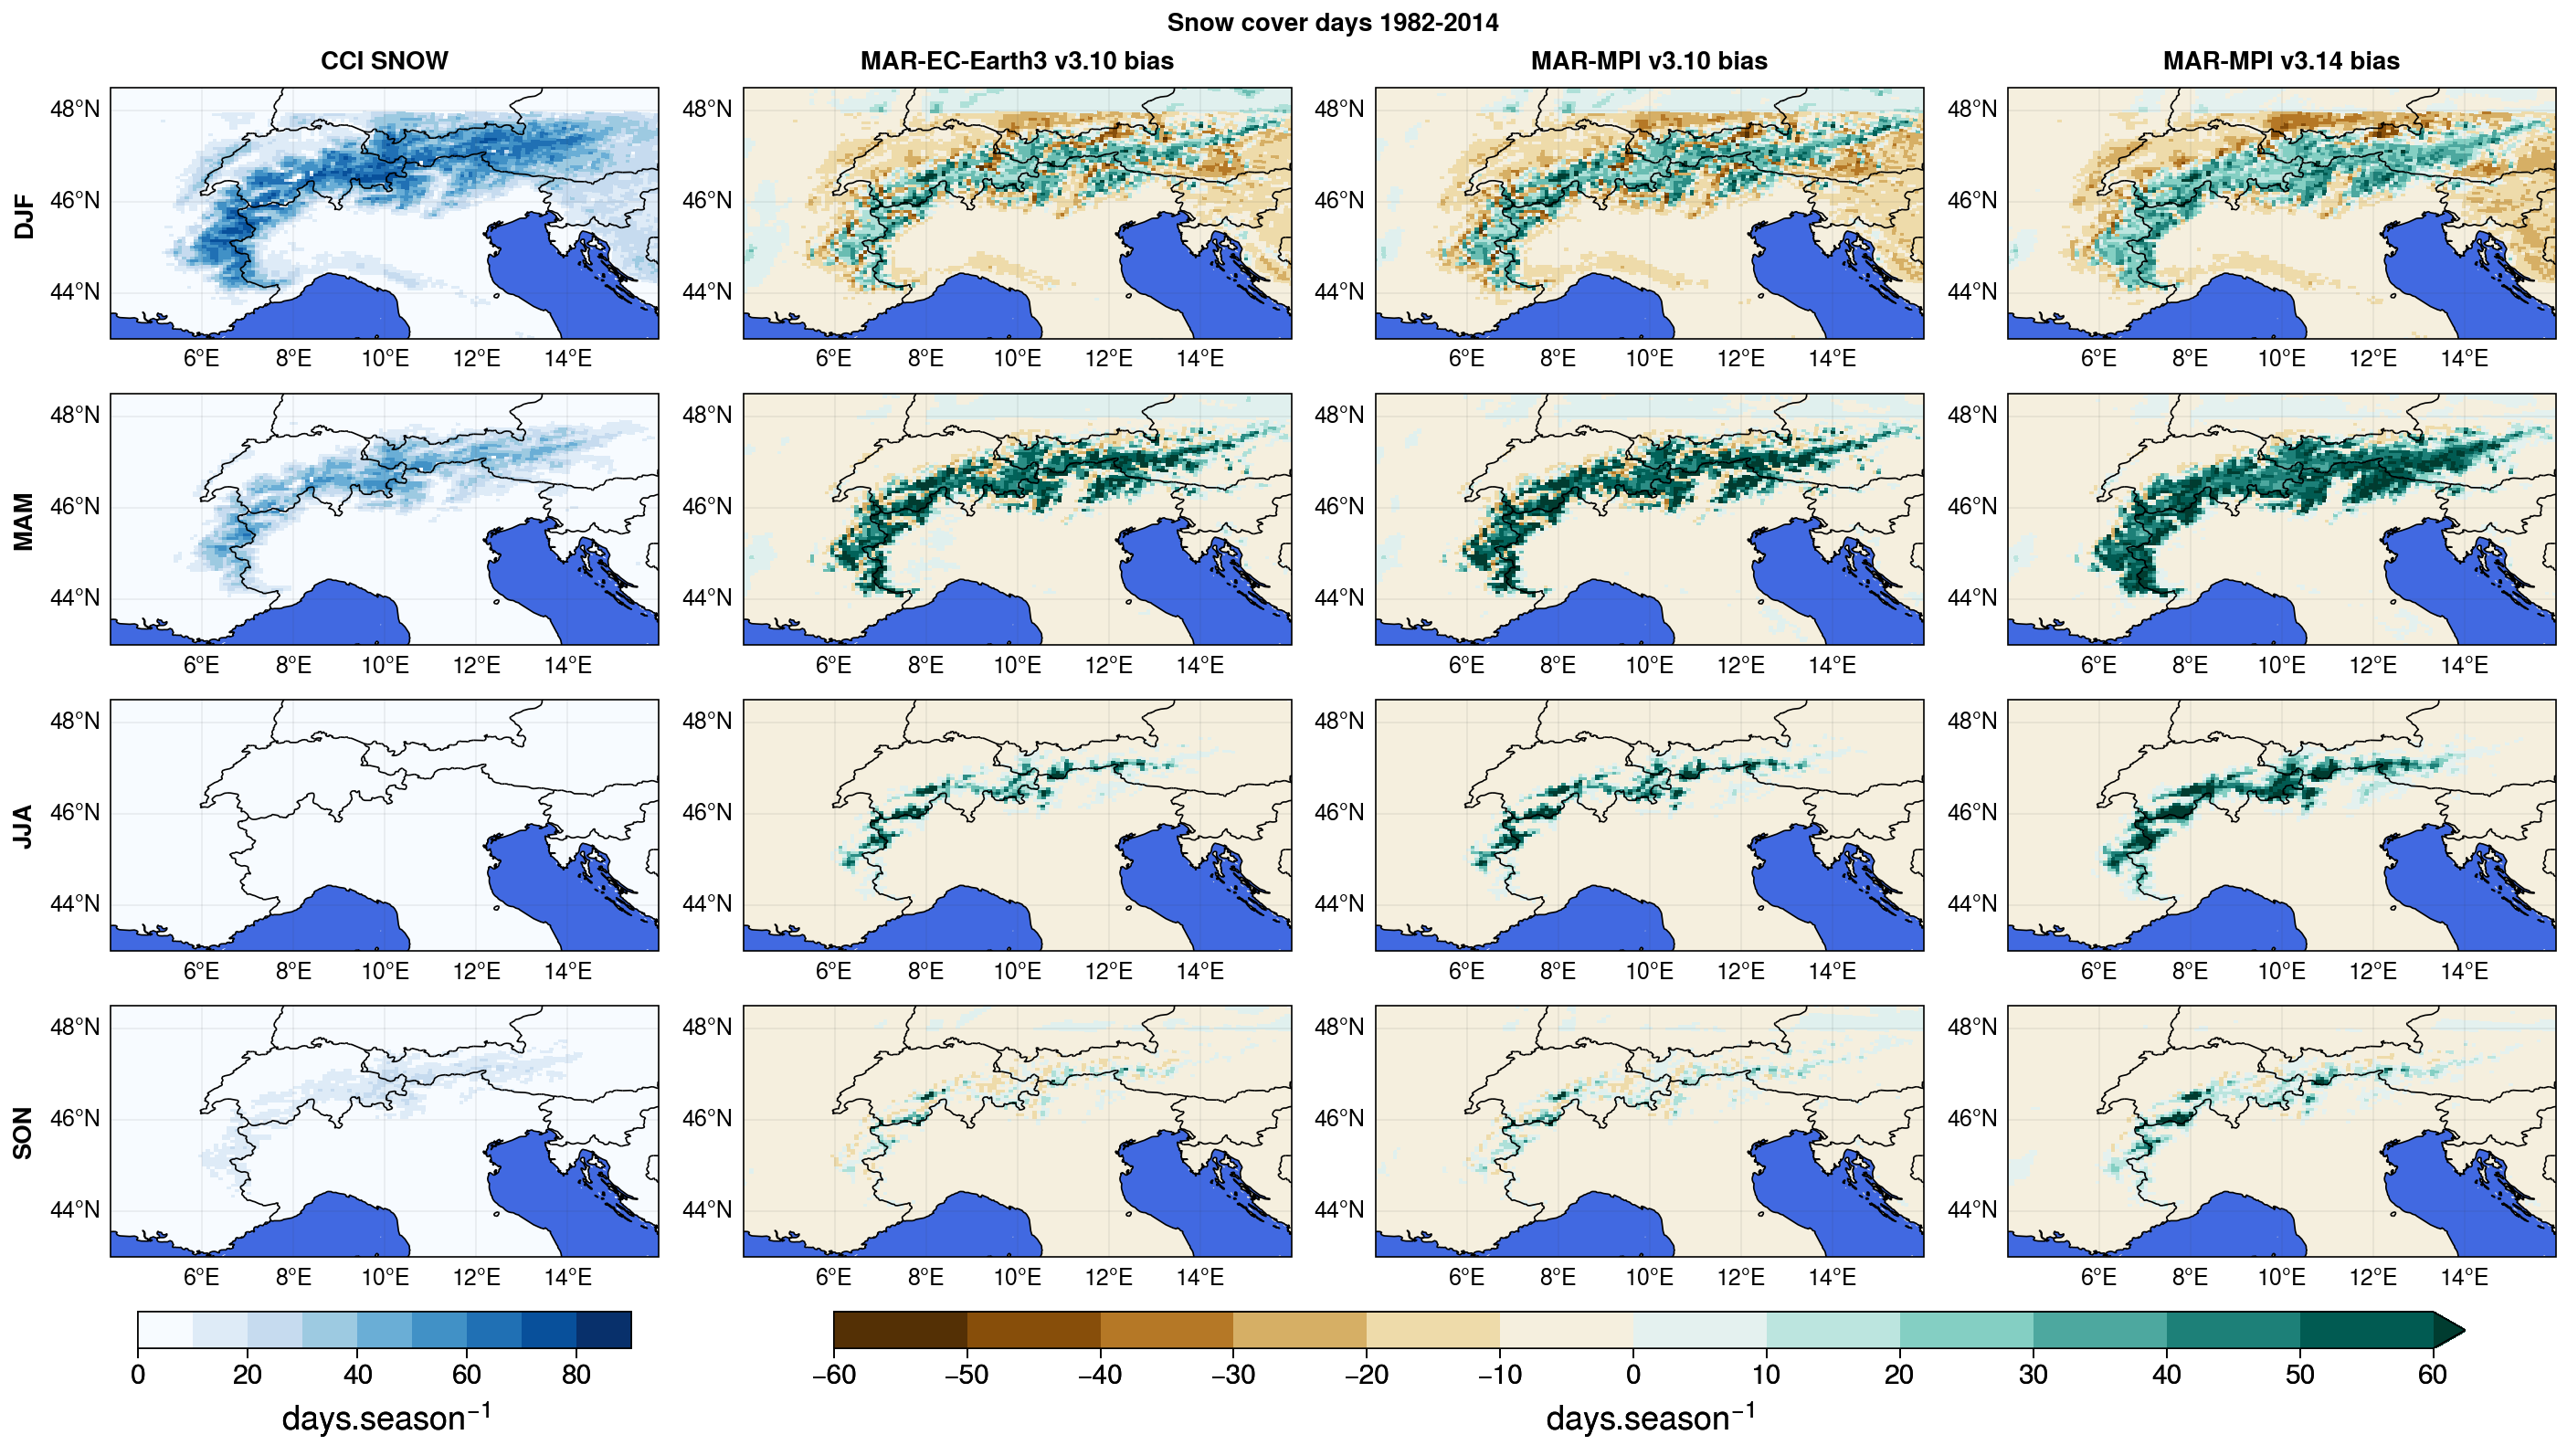

In [26]:
pplt.rc['figure.facecolor'] = 'white'

f, axs = pplt.subplots(proj='cyl', axwidth=3,axheight=1.5,ncols=4,nrows=4)

nb_yrs = 33 # from 1982 to 2014

colmap = 'Blues'
colmap2 = 'BrBG'
#levels_seas = [np.arange(-15,15,2.5),np.arange(-10,20,2.5),np.arange(-5,35,2.5),np.arange(-10,25,2.5)]
levels_seas = np.arange(0,100,10)
levels_seas2 = np.arange(-60,70,10)

for seas in range(4):
    m=axs[4*seas].pcolormesh(lon, lat, ds_CCI_SNOW_seas_thresh50_regrid.nbdays_filled[seas]/nb_yrs, levels=levels_seas,cmap=colmap)

    m2=axs[4*seas+1].pcolormesh(lon, lat, (ds_v310_EC_snowdays_seas.isel(season=seas) - ds_CCI_SNOW_seas_thresh50_regrid.nbdays_filled[seas])/nb_yrs,
                                levels=levels_seas2,cmap=colmap2)
    
    m2=axs[4*seas+2].pcolormesh(lon, lat, (ds_v310_snowdays_seas.isel(season=seas) - ds_CCI_SNOW_seas_thresh50_regrid.nbdays_filled[seas])/nb_yrs,
                                levels=levels_seas2,cmap=colmap2)
    
    m2=axs[4*seas+3].pcolormesh(lon, lat, (ds_v314_snowdays_seas.isel(season=seas) - ds_CCI_SNOW_seas_thresh50_regrid.nbdays_filled[seas])/nb_yrs,
                                levels=levels_seas2,cmap=colmap2,extend='max')


f.colorbar(m,label= 'days.$season^{-1}$',labelsize='x-large',ticklabelsize='large',loc='b',col=1,length=0.9)
f.colorbar(m2,label= 'days.$season^{-1}$',labelsize='x-large',ticklabelsize='large',loc='b',cols=(2,4),length=0.9)

f.format(**normal_format)
f.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],rowlabels=['DJF','MAM','JJA','SON'],
         collabels=['CCI SNOW','MAR-EC-Earth3 v3.10 bias','MAR-MPI v3.10 bias','MAR-MPI v3.14 bias'],suptitle='Snow cover days 1982-2014')
